# USD MSADS 505 Final Project - Team 3
# Caleb McCurdy, Jesse Gutierrez, and Jessica Hin

Importing required libraries and packages

In [3]:
import klib
import os
import dmba
import kds
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sma
import statsmodels.tools.tools as stattools
import scipy.stats as stats
import tensorflow as tf

from klib import corr_plot

from scipy.stats import yeojohnson

from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from tensorflow import keras

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba.metric import AIC_score

from imblearn.over_sampling import RandomOverSampler

%matplotlib inline


This code chunk is to prevent lengthy warning messages from appearing during notebook rendering.

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


# Part 1 - EDA
## Describing the data and data information

In [6]:
# Load the bank-full spreadsheet
df = pd.read_csv('C:/Users/jessh/Documents/ADS505_Team3/bank-full.csv', delimiter= ';')
# Display the first 5 rows to preview table
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
# Display the dimension of the spreadsheet
df.shape

(45211, 17)

In [8]:
# Display column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [9]:
# Display the data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [10]:
# Display null values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [11]:
# getting the statistical summary of the data
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [12]:
# Display unique outputs
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

Identifying which variables are numeric and which ones are catgorical.

In [13]:
# create subsets of the variables by type
num_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# updating objects to categorical type
df[cat_vars] = df[cat_vars].astype('category') 

In [14]:
# Subset the data to only have the numeric data
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Display the header
numeric_df.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


## Visualizations the numeric variables  
### Boxplots

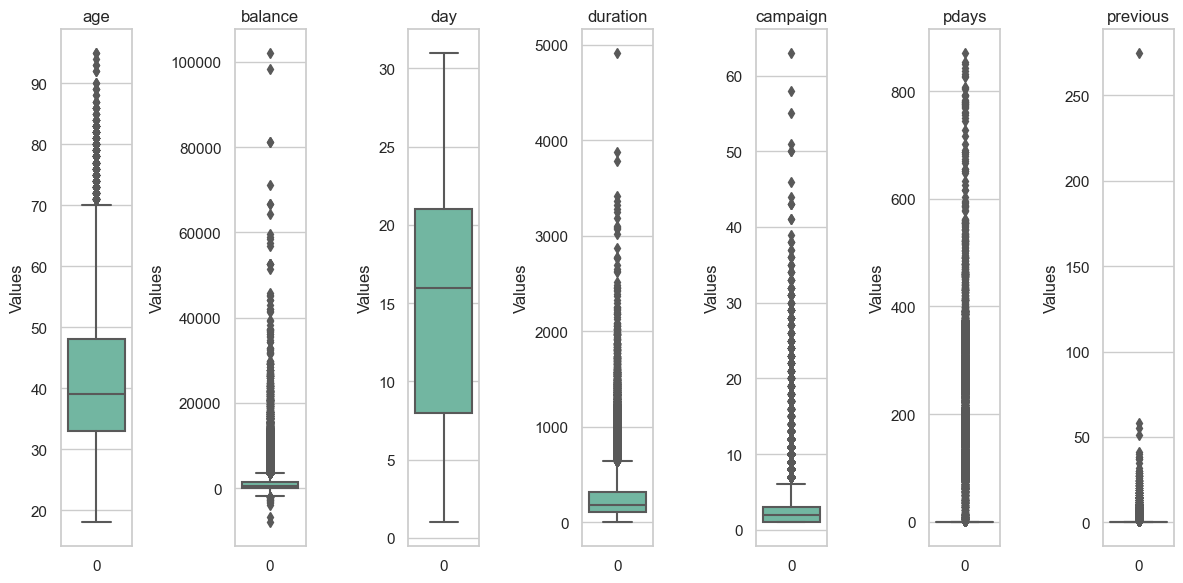

In [15]:
# Establish the style for the plots
sns.set(style="whitegrid")

# Create separate boxplots for each numeric column
plt.figure(figsize=(12, 6))

# Create a loop to generate independent subplots
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(1, len(numeric_df.columns), i)
    sns.boxplot(data=numeric_df[col], orient="v", palette="Set2")
    plt.title(f'{col}')
    plt.ylabel('Values')
# Combine & display outputs
plt.tight_layout()
plt.show()

Through the above box plot visualization, we were able to see the distribution of values among each numeric attribute while also identifying outliers.

### Scatterplots

In [ ]:
# Plot observations among all numeric attributes to compare distribution

# Establish the style for the plots
sns.set(style="ticks")

# Create pairplot
sns.pairplot(numeric_df, diag_kind='kde', markers='o')

# Display the plots
plt.show()

### Histograms

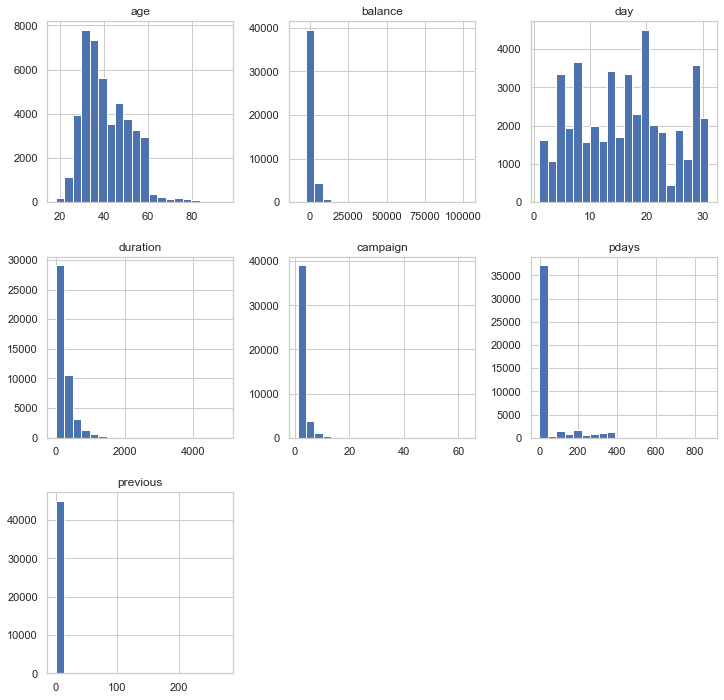

In [13]:
df[num_vars].hist(figsize=(12,12),bins=20)
plt.show()

As seen in the histograms, many of the numeric attributes are skewed right.

### Correlation Plot

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

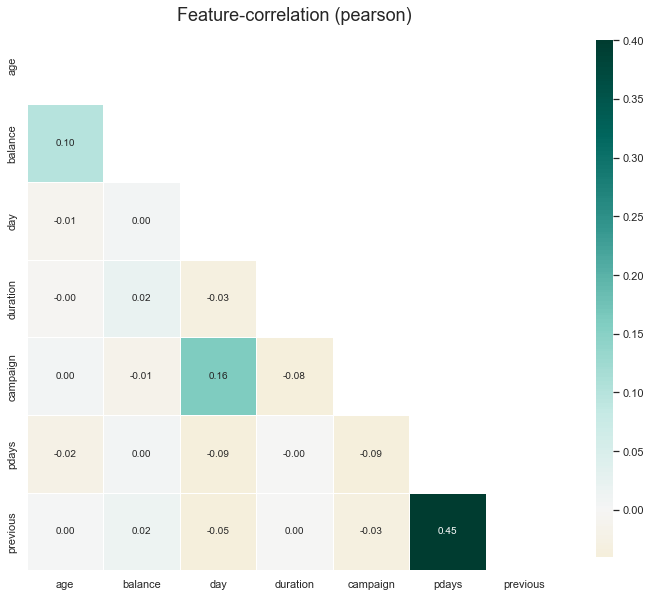

In [14]:
klib.corr_plot(df[num_vars])

## Visualizations of the categorical variables  
### Histograms with respect to the response variable 'y'

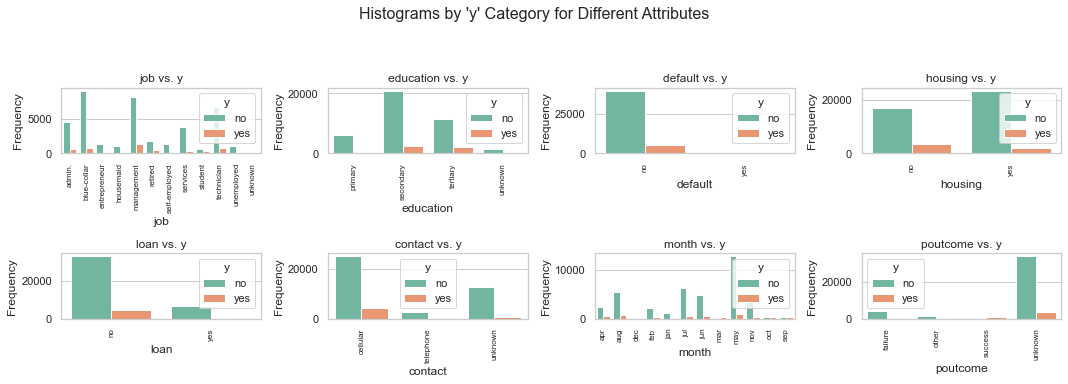

In [15]:
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# List of columns to include in the grid
columns_to_compare = ['job', 'education', 'default', 'housing', 'loan', 'contact',
                      'month', 'poutcome']

# Create a grid of histograms comparing each column to 'y'
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.suptitle("Histograms by 'y' Category for Different Attributes", fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through the specified columns and create histograms for each
for i, col in enumerate(columns_to_compare):
    ax = axes[i]
    
    # Rotate x-axis labels by 45 degrees and set a smaller font size
    sns.countplot(data=df, x=col, hue='y', ax=ax, palette="Set2")
    ax.set_title(f'{col} vs. y')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The grid of plots allow for a closer analysis of the distribution of observations with a yes value for 'y.' This helps us understand which type of contact, background information, and time period may potentially influence the predicted output.

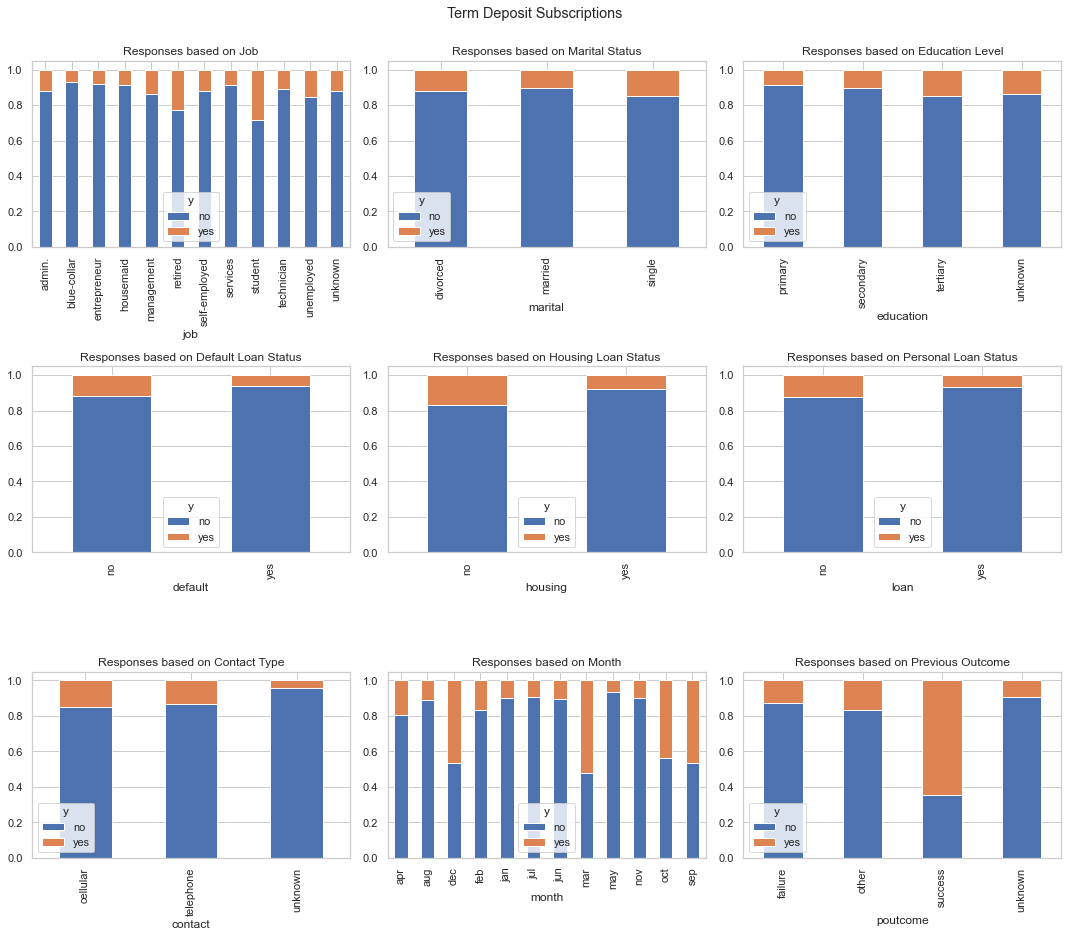

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by job
ax0 = pd.crosstab(df['job'], df['y'])
ax0 = ax0.div(ax0.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][0])
ax0.set_title('Responses based on Job')

# plotting by marital
ax1 = pd.crosstab(df['marital'], df['y'])
ax1 = ax1.div(ax1.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][1])
ax1.set_title('Responses based on Marital Status')

# plotting by education
ax2 = pd.crosstab(df['education'], df['y'])
ax2 = ax2.div(ax2.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[0][2])
ax2.set_title('Responses based on Education Level')

# plotting by default
ax3 = pd.crosstab(df['default'], df['y'])
ax3 = ax3.div(ax3.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][0])
ax3.set_title('Responses based on Default Loan Status')

# plotting by housing
ax4 = pd.crosstab(df['housing'], df['y'])
ax4 = ax4.div(ax4.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][1])
ax4.set_title('Responses based on Housing Loan Status')

# plotting by loan
ax5 = pd.crosstab(df['loan'], df['y'])
ax5 = ax5.div(ax5.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[1][2])
ax5.set_title('Responses based on Personal Loan Status')

# plotting by contact
ax6 = pd.crosstab(df['contact'], df['y'])
ax6 = ax6.div(ax6.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][0])
ax6.set_title('Responses based on Contact Type')

# plotting by month
ax7 = pd.crosstab(df['month'], df['y'])
ax7 = ax7.div(ax7.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][1])
ax7.set_title('Responses based on Month')

# plotting by poutcome
ax8 = pd.crosstab(df['poutcome'], df['y'])
ax8 = ax8.div(ax8.sum(1),axis = 0).plot(kind='bar', stacked = True, ax=axes[2][2])
ax8.set_title('Responses based on Previous Outcome')

plt.tight_layout()
plt.show()

The plots show that there is a larger relative number of students and retired that have a desired predicted output. In adddition, March and December are the months that had the largest amount of people subscribe to a term deposit.

### Boxplots of categorical variables with respect to y

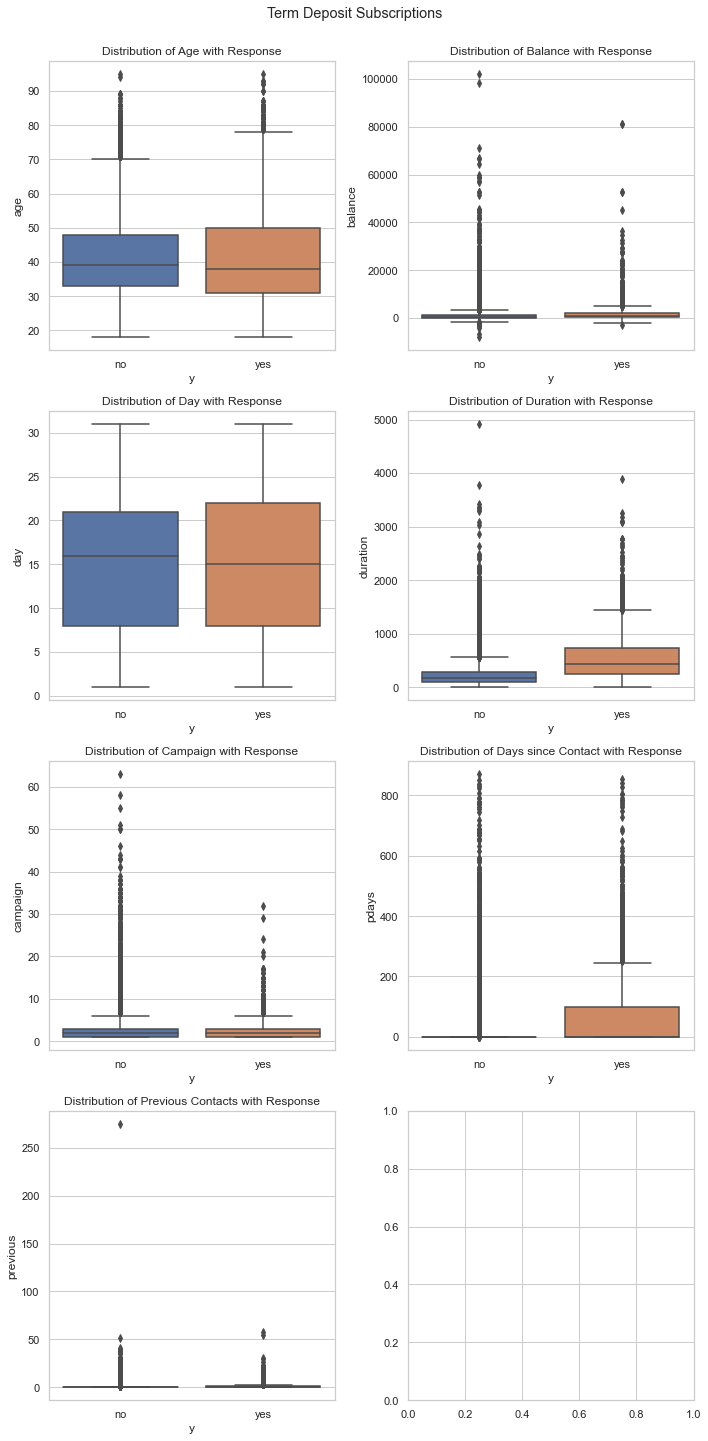

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
fig.suptitle('Term Deposit Subscriptions', y=1)

# plotting by age
ax0 = sns.boxplot(y="age", x='y', data=df, ax = axes[0][0])
ax0.set_title('Distribution of Age with Response')

# plotting by balance
ax1 = sns.boxplot(y="balance", x='y', data=df, ax = axes[0][1])
ax1.set_title('Distribution of Balance with Response')

# plotting by day
ax2 = sns.boxplot(y="day", x='y', data=df, ax = axes[1][0])
ax2.set_title('Distribution of Day with Response')

# plotting by duration
ax3 = sns.boxplot(y="duration", x='y', data=df, ax = axes[1][1])
ax3.set_title('Distribution of Duration with Response')

# plotting by campaign
ax4 = sns.boxplot(y="campaign", x='y', data=df, ax = axes[2][0])
ax4.set_title('Distribution of Campaign with Response')

# plotting by pdays
ax5 = sns.boxplot(y="pdays", x='y', data=df, ax = axes[2][1])
ax5.set_title('Distribution of Days since Contact with Response')

# plotting by previous
ax6 = sns.boxplot(y="previous", x='y', data=df, ax = axes[3][0])
ax6.set_title('Distribution of Previous Contacts with Response')

plt.tight_layout()
plt.show()

## Visualizations for the records that had 'y' = Yes

In [18]:
# Categorical columns to analyze
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign', 'previous', 'poutcome']

# Varaible used to store the results
results = []

# Iterate through the categorical columns
for col in categorical_columns:
    unique_values = df[col].unique()
    for value in unique_values:
        sub_df = df[df[col] == value]
        total_count = sub_df.shape[0]  
        yes_count = sub_df[sub_df['y'] == 'yes'].shape[0]
        percentage = (yes_count / total_count) * 100 if total_count > 0 else 0.0
        results.append({'Column': col, 'Value': value, 'Percentage': percentage, 'Total Frequency': total_count})

# Save the results as a Data Frame
result_df = pd.DataFrame(results)

# Sort results in descending order
result_df = result_df.sort_values(by='Percentage', ascending=False)

# Display top 20 unique values
result_df.head(20)

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
132,poutcome,success,64.725347,1511
37,month,mar,51.991614,477
106,previous,26,50.000000,2
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
97,previous,10,38.805970,67
121,previous,30,33.333333,3


In [19]:
# Wanted to further look at the distribution among each attribute
month_df = result_df[result_df['Column'] == 'month']
# Display table
month_df

,Column,Value,Percentage,Total Frequency
37,month,mar,51.991614,477
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
38,month,apr,19.679400,2932
36,month,feb,16.647792,2649
31,month,aug,11.013286,6247
29,month,jun,10.222805,5341
33,month,nov,10.151134,3970
35,month,jan,10.121169,1403


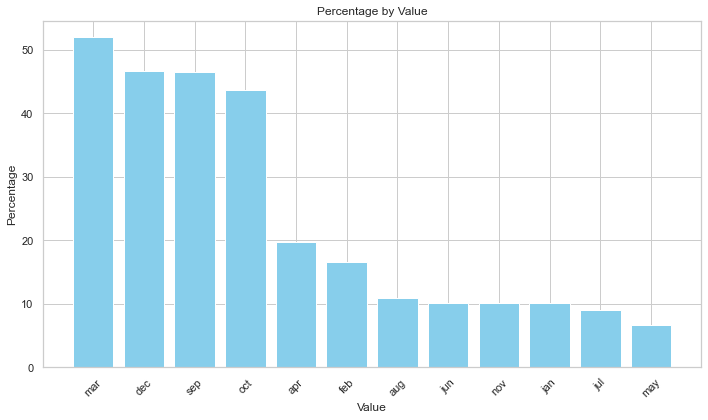

In [20]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(month_df['Value'], month_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in month_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [21]:
# Wanted to further look at the distribution among each attribute
marital_df = result_df[result_df['Column'] == 'marital']
# Display table
marital_df

,Column,Value,Percentage,Total Frequency
13,marital,single,14.949179,12790
14,marital,divorced,11.945458,5207
12,marital,married,10.123466,27214


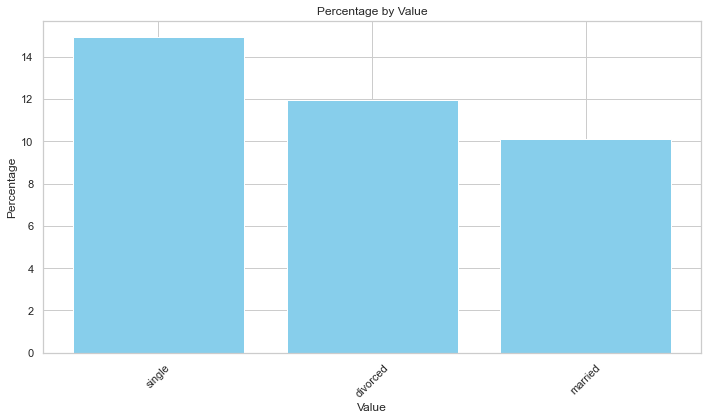

In [22]:
# Create bar plot for marital status
plt.figure(figsize=(10, 6))
plt.bar(marital_df['Value'], marital_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in marital_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [23]:
# Wanted to further look at the distribution among each attribute
job_df = result_df[result_df['Column'] == 'job']
# Display table
job_df

,Column,Value,Percentage,Total Frequency
11,job,student,28.678038,938
5,job,retired,22.791519,2264
9,job,unemployed,15.502686,1303
0,job,management,13.755551,9458
6,job,admin.,12.202669,5171
8,job,self-employed,11.842939,1579
4,job,unknown,11.805556,288
1,job,technician,11.056996,7597
7,job,services,8.883004,4154
10,job,housemaid,8.790323,1240


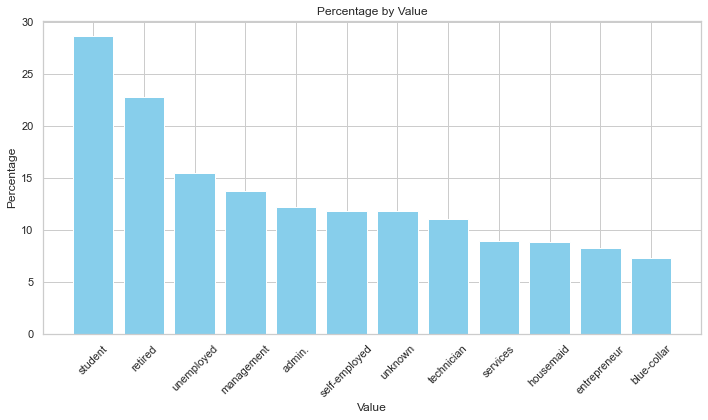

In [24]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(job_df['Value'], job_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in job_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [25]:
# Wanted to further look at the distribution among each attribute
education_df = result_df[result_df['Column'] == 'education']
# Display table
education_df

,Column,Value,Percentage,Total Frequency
15,education,tertiary,15.006390,13301
17,education,unknown,13.570275,1857
16,education,secondary,10.559435,23202
18,education,primary,8.626478,6851


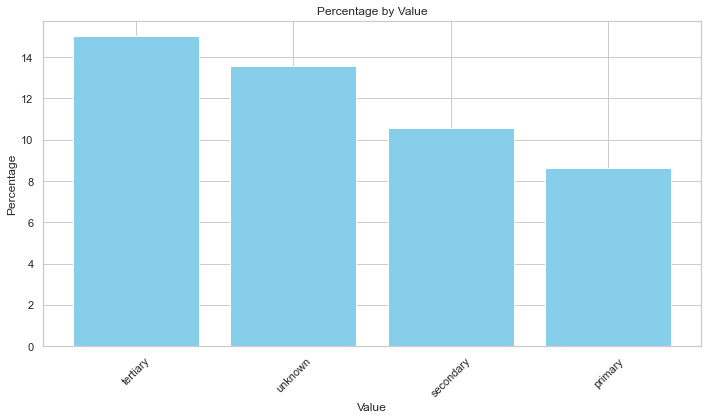

In [26]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(education_df['Value'], education_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in education_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [27]:
# Wanted to further look at the distribution among each attribute
default_df = result_df[result_df['Column'] == 'default']
# Display table
default_df

,Column,Value,Percentage,Total Frequency
19,default,no,11.796108,44396
20,default,yes,6.380368,815


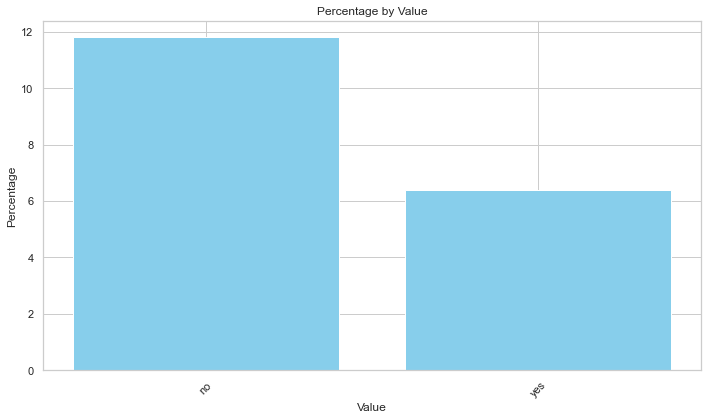

In [28]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(default_df['Value'], default_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in default_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [29]:
# Wanted to further look at the distribution among each attribute
housing_df = result_df[result_df['Column'] == 'housing']
# Display table
housing_df

,Column,Value,Percentage,Total Frequency
22,housing,no,16.702355,20081
21,housing,yes,7.699960,25130


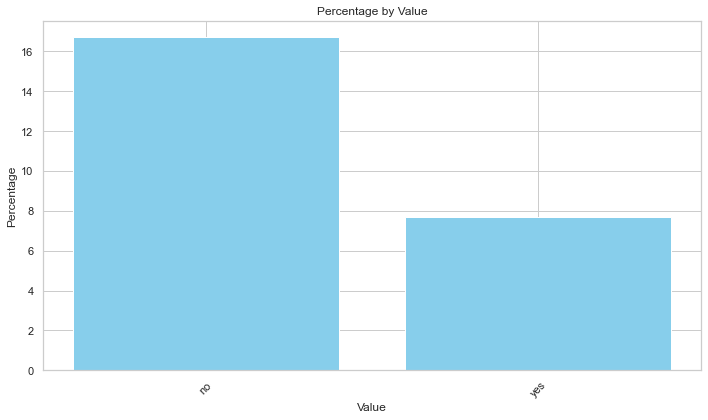

In [30]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(housing_df['Value'], housing_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in housing_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [31]:
# Wanted to further look at the distribution among each attribute
loan_df = result_df[result_df['Column'] == 'loan']
# Display table
loan_df

,Column,Value,Percentage,Total Frequency
23,loan,no,12.655727,37967
24,loan,yes,6.681391,7244


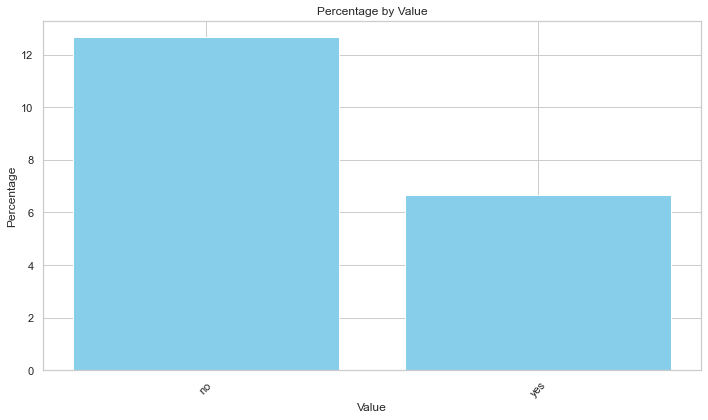

In [32]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(loan_df['Value'], loan_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in loan_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [33]:
# Wanted to further look at the distribution among each attribute
contact_df = result_df[result_df['Column'] == 'contact']
# Display table
contact_df

,Column,Value,Percentage,Total Frequency
26,contact,cellular,14.918900,29285
27,contact,telephone,13.420509,2906
25,contact,unknown,4.070661,13020


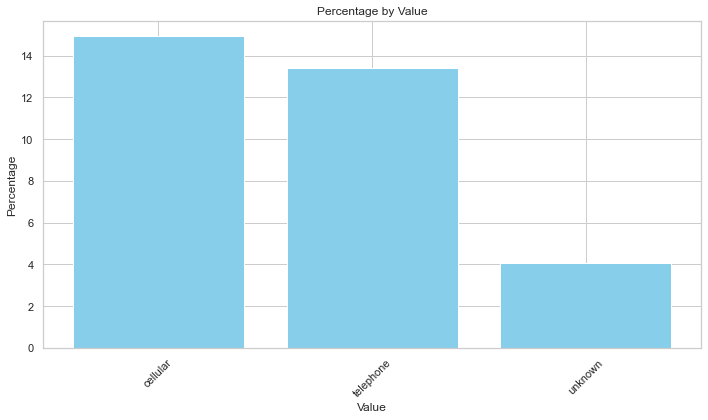

In [34]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(contact_df['Value'], contact_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in contact_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [35]:
# Wanted to further look at the distribution among each attribute
campaign_df = result_df[result_df['Column'] == 'campaign']
# Display table
campaign_df

,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


In [36]:
# Determine the min. freq. to display w/in table using 5%
campaign_cutoff = round(len(campaign_df) * .05, 0)
# Display the minimum amount of observations that a value needs to be included
print('Minumum observations for campaign results: ', campaign_cutoff)
# Display table
campaign_cutoff_df = campaign_df[campaign_df['Total Frequency'] > campaign_cutoff] 
# Print updated table
campaign_cutoff_df

Minumum observations for campaign results:  2.0


,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


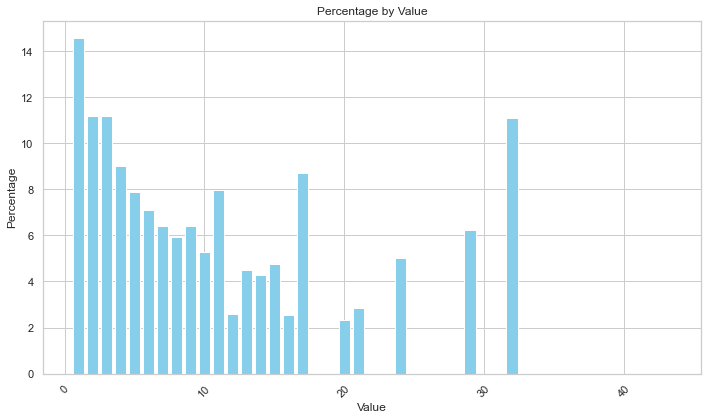

In [37]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(campaign_cutoff_df['Value'], campaign_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in campaign_cutoff_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [38]:
# Wanted to further look at the distribution among each attribute
previous_df = result_df[result_df['Column'] == 'previous']
# Display table
previous_df

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
106,previous,26,50.000000,2
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19


In [39]:
# Establish min. freq. based on cutoff value of 5%
percentage_cutoff = round(len(previous_df) * .05, 0)
# Display the min. amount of freq.
print('Percent cutoff: ', percentage_cutoff)
# Create a subset accounting for cutoff
previous_cutoff_df = previous_df[previous_df['Total Frequency'] > percentage_cutoff]
# Display results
previous_cutoff_df

Percent cutoff:  2.0


,Column,Value,Percentage,Total Frequency
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19
101,previous,9,26.086957,92
89,previous,3,25.744308,1142
102,previous,21,25.000000,4


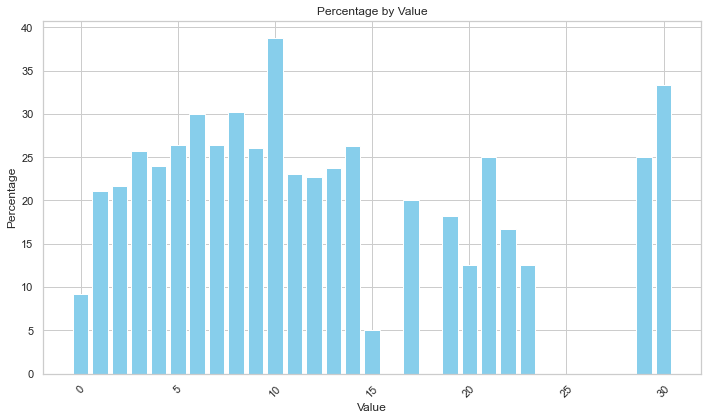

In [40]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(previous_cutoff_df['Value'], previous_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [ ]:
# Use a One Way Anova to determine if there is a significant difference between the unique values
groups = [group['Percentage'] for name, group in previous_cutoff_df.groupby('Value')]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

# Establish p-value cutoff to determine significance
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

In [41]:
# Wanted to further look at the distribution among each attribute
poutcome_df = result_df[result_df['Column'] == 'poutcome']
# Display table
poutcome_df

,Column,Value,Percentage,Total Frequency
132,poutcome,success,64.725347,1511
131,poutcome,other,16.684783,1840
130,poutcome,failure,12.609671,4901
129,poutcome,unknown,9.161503,36959


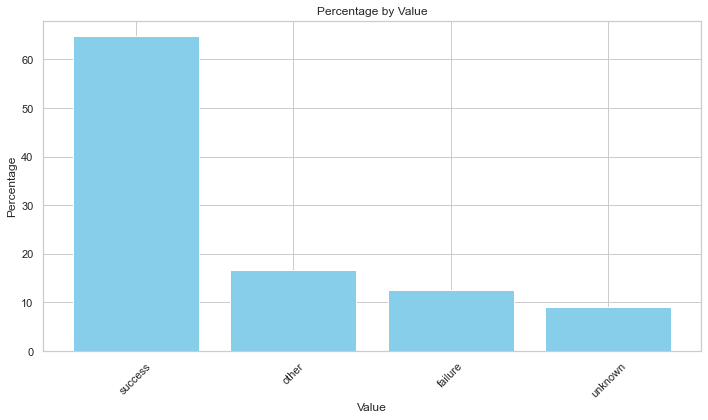

In [42]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(poutcome_df['Value'], poutcome_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Part 2 - Data Preprocessing

In [16]:
# replacing the -1 with 0 in the pdays variable
df['pdays'] = df['pdays'].replace(-1, 0)

## Split the dataset

In [58]:
# train (80%), validation (15%), test (5%) 
y = df[['y']]
X = df.drop(columns=['y'])
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.20, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.25, random_state=1)

In [18]:
# Display the dimensions of the data splits
print('The dimensions of the X train undersampled dataset is:', X_train.shape)
print('The dimensions of the Y train undersampled dataset is:', y_train.shape)
print('The dimensions of the X validation dataset is:', X_val.shape)
print('The dimensions of the Y validation dataset is:', y_val.shape)
print('The dimensions of the X test dataset is:', X_test.shape)
print('The dimensions of the Y test dataset is:', y_test.shape)

The dimensions of the X train undersampled dataset is: (36168, 16)
The dimensions of the Y train undersampled dataset is: (36168, 1)
The dimensions of the X validation dataset is: (6782, 16)
The dimensions of the Y validation dataset is: (6782, 1)
The dimensions of the X test dataset is: (2261, 16)
The dimensions of the Y test dataset is: (2261, 1)


In [19]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
22468,52,management,married,tertiary,no,0,no,no,cellular,22,aug,232,2,0,0,unknown
6896,50,admin.,single,secondary,no,330,yes,no,unknown,28,may,24,1,0,0,unknown
28408,45,blue-collar,married,primary,no,300,yes,no,cellular,29,jan,203,1,261,3,failure
8481,38,technician,married,secondary,no,27,yes,no,unknown,3,jun,404,4,0,0,unknown
28753,31,services,single,secondary,no,887,no,no,cellular,30,jan,427,1,0,0,unknown


## Transforming the data

In [59]:
# using the yeojohnson transformation because it can take both negative and postive numbers
X_train[num_vars] = X_train[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_test[num_vars] = X_test[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)
X_val[num_vars] = X_val[num_vars].apply(lambda x: yeojohnson(x)[0] , axis=0)

## Scaling

In [60]:
# Redefine cat_vars to not include the response variable
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create pipelines for cat and num variables
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_pipe = Pipeline([('standardize', StandardScaler())])

# Combine pipelines using ColumnTransformer
all_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_vars),
        ('num', num_pipe, num_vars)
    ],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_trans = all_pipe.fit_transform(X_train)

# Get feature names for one-hot encoded cat variables
cat_encoder = all_pipe.named_transformers_['cat'].named_steps['encoder']
cat_encoder.fit(X_train[cat_vars])

# get cat feature names
cat_col_names = cat_encoder.get_feature_names_out(cat_vars)

# all feature names
all_col_names = list(cat_col_names) + num_vars

# Reassign the column names to the transformed datasets
X_train_trans = pd.DataFrame(X_train_trans, columns=all_col_names)
X_val_trans = pd.DataFrame(all_pipe.transform(X_val), columns=all_col_names)
X_test_trans = pd.DataFrame(all_pipe.transform(X_test), columns=all_col_names)

In [22]:
# Display preview of the results
X_train_trans

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.067420,-0.429147,0.767483,0.251846,0.127678,-0.471096,-0.471215
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.919258,-0.251638,1.376140,-1.952865,-1.112671,-0.471096,-0.471215
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.516420,-0.265243,1.473611,0.101383,-1.112671,2.134551,2.172014
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.144743,-0.407672,-1.690601,0.907102,1.086380,-0.471096,-0.471215
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.964915,-0.023747,1.570082,0.975265,-1.112671,-0.471096,-0.471215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.919258,0.312413,-0.128635,0.618253,0.731296,-0.471096,-0.471215
36164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.589561,-0.166225,0.221526,0.256739,0.127678,-0.471096,-0.471215
36165,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.764013,1.049850,0.661494,0.776805,1.483760,-0.471096,-0.471215
36166,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.516420,0.296505,0.554003,-2.545711,1.884528,-0.471096,-0.471215


In [49]:
# Review the datatype & null-values in the transformed train dataset
X_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_admin.           36168 non-null  float64
 1   job_blue-collar      36168 non-null  float64
 2   job_entrepreneur     36168 non-null  float64
 3   job_housemaid        36168 non-null  float64
 4   job_management       36168 non-null  float64
 5   job_retired          36168 non-null  float64
 6   job_self-employed    36168 non-null  float64
 7   job_services         36168 non-null  float64
 8   job_student          36168 non-null  float64
 9   job_technician       36168 non-null  float64
 10  job_unemployed       36168 non-null  float64
 11  job_unknown          36168 non-null  float64
 12  marital_divorced     36168 non-null  float64
 13  marital_married      36168 non-null  float64
 14  marital_single       36168 non-null  float64
 15  education_primary    36168 non-null 

In [61]:
## Convert 'no' to 0 and 'yes' to 1 in y sets
y_train['y'] = y_train['y'].map({'no': 0, 'yes': 1})
y_val['y'] = y_val['y'].map({'no': 0, 'yes': 1})
y_test['y'] = y_test['y'].map({'no': 0, 'yes': 1})

## Balancing

In [62]:
# Combine the transformed X_train and y_train into a single DataFrame
X_train_trans.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
balanced_train_data = pd.concat([X_train_trans, y_train], axis=1)

# Separate the majority (0) and minority (1) classes
major_class = balanced_train_data[balanced_train_data['y'] == 0]
minor_class = balanced_train_data[balanced_train_data['y'] == 1]

In [25]:
balanced_train_data

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.067420,-0.429147,0.767483,0.251846,0.127678,-0.471096,-0.471215,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.919258,-0.251638,1.376140,-1.952865,-1.112671,-0.471096,-0.471215,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.516420,-0.265243,1.473611,0.101383,-1.112671,2.134551,2.172014,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.144743,-0.407672,-1.690601,0.907102,1.086380,-0.471096,-0.471215,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,-0.964915,-0.023747,1.570082,0.975265,-1.112671,-0.471096,-0.471215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.919258,0.312413,-0.128635,0.618253,0.731296,-0.471096,-0.471215,0
36164,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.589561,-0.166225,0.221526,0.256739,0.127678,-0.471096,-0.471215,0
36165,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.764013,1.049850,0.661494,0.776805,1.483760,-0.471096,-0.471215,0
36166,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.516420,0.296505,0.554003,-2.545711,1.884528,-0.471096,-0.471215,0


### Undersampling majority class

In [63]:
# undersample the minority class to match the number of majority class samples
major_class_under = resample(major_class, replace=True, n_samples=len(minor_class), random_state=1)

# Combine the oversampled minority class with the majority class
train_data_under = pd.concat([minor_class, major_class_under])

# Separate the features (X) and the target (y) from the balanced training data
X_train_under = train_data_under.drop(columns=['y'])
y_train_under = train_data_under[['y']]

In [27]:
# Display the dimensions of the undersampled train dataset
print('The dimensions of the X train undersampled dataset is:', X_train_under.shape)
print('The dimensions of the Y train undersampled dataset is:', y_train_under.shape)
print('The dimensions of the X validation dataset is:', X_val.shape)
print('The dimensions of the Y validation dataset is:', y_val.shape)
print('The dimensions of the X test dataset is:', X_test.shape)
print('The dimensions of the Y test dataset is:', y_test.shape)

The dimensions of the X train undersampled dataset is: (8478, 51)
The dimensions of the Y train undersampled dataset is: (8478, 1)
The dimensions of the X validation dataset is: (6782, 16)
The dimensions of the Y validation dataset is: (6782, 1)
The dimensions of the X test dataset is: (2261, 16)
The dimensions of the Y test dataset is: (2261, 1)


In [28]:
display(X_train_under)
display(y_train_under)

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,-3.280074,-0.243576,-1.352167,1.020834,1.086380,-0.471096,-0.471215
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.099443,0.698421,0.872056,0.341843,-1.112671,2.139217,2.028412
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,-0.710280,0.246286,-1.516112,1.388043,-1.112671,2.107423,2.028412
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.248818,-0.413267,0.554003,1.906156,1.086380,-0.471096,-0.471215
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,-0.964915,0.294130,-0.009694,0.191672,-1.112671,2.132162,2.028412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17463,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.835301,-0.257960,-0.765944,-2.371574,1.086380,-0.471096,-0.471215
20359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.589561,0.217598,0.554003,0.084777,0.127678,-0.471096,-0.471215
4145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.516420,-0.188461,1.570082,0.242007,0.127678,-0.471096,-0.471215
34807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.964915,-0.429147,0.221526,-0.075205,-1.112671,-0.471096,-0.471215


,y
21,1
44,1
47,1
50,1
73,1
...,...
17463,0
20359,0
4145,0
34807,0


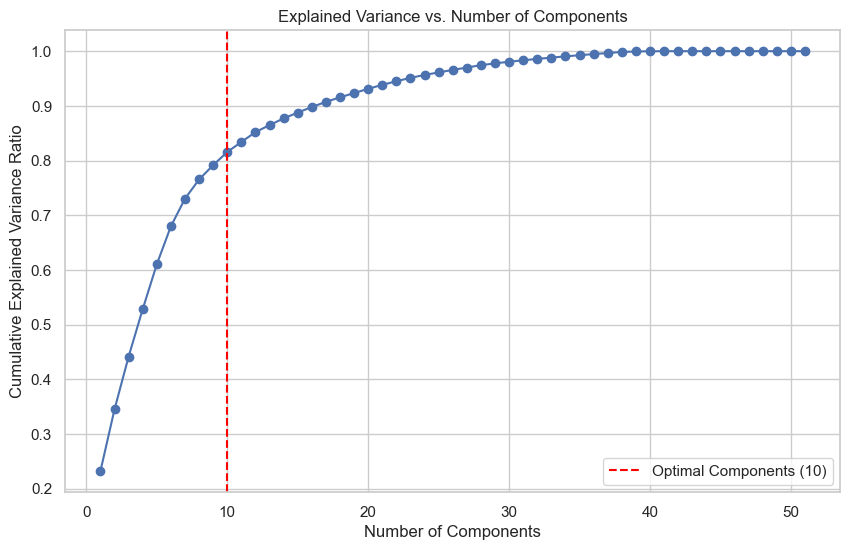

Optimal number of components: 10


In [29]:
# Initialize PCA with a large number of components
pca = PCA()

# Fit PCA on your scaled data
pca.fit(X_train_under)

# Plot the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title("Explained Variance vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

# Determine the optimal number of components based on the plot
# You can choose a threshold (e.g., 0.95) and find the corresponding number of components
threshold = 0.8
optimal_num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

plt.axvline(x=optimal_num_components, color='red', linestyle='--', label=f'Optimal Components ({optimal_num_components})')
plt.legend()

plt.show()

print(f"Optimal number of components: {optimal_num_components}")

In [31]:
# I deemed 10 as the ideal number of components capturing >80% of cumulative explained variance
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_under)

# Convert to a DataFrame from X_pca w/ original column names
pca_column_names = [f'PC{i}' for i in range(1, 11)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_column_names)

# Create a dictionary to map PCA column names to original
pca_to_original_mapping = {pca_column_names[i]: X_train_under.columns[i] for i in range(10)}  # Start from 0

# Use the mapping to match PCA component names to original columns
matching_columns = [pca_to_original_mapping[pca_col] for pca_col in X_pca_df.columns]

# Rename column names
X_pca_df.rename(columns=pca_to_original_mapping, inplace=True)

# Add 'y' column from df_factors_imputed to X_pca_df
X_pca_df['y'] = np.array(y_train_under)

# Display table
X_pca_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,y
0,-1.058468,-3.132372,0.648605,0.046842,0.666228,1.911139,-0.605232,-0.310217,0.338098,0.489529,1
1,2.931253,-1.168014,-0.209254,1.135605,0.854280,-0.847056,-0.747197,0.148655,0.304991,0.032277,1
2,3.027359,-1.301493,1.388116,-0.730517,0.212959,0.196623,0.303129,0.785315,0.163285,-0.650392,1
3,-1.111777,0.225466,0.663448,1.162806,-1.217544,0.738859,-0.723384,-0.958217,0.212157,-0.600681,1
4,2.872375,-1.207414,-0.103645,0.047071,0.650483,-0.537218,-0.394656,-0.891789,0.709182,0.076522,1


In [32]:
# Display the dimensions of the dataset
X_pca_df.shape

(8478, 11)

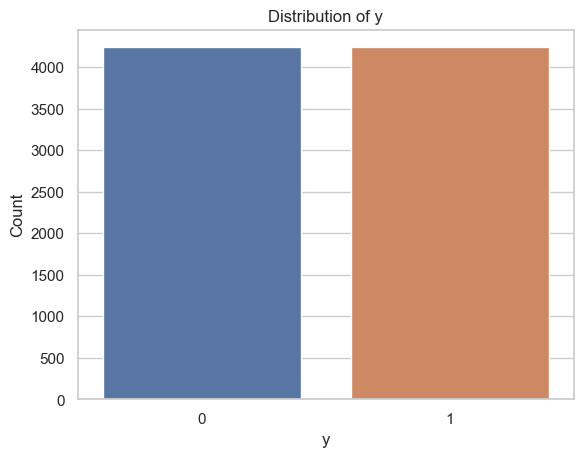

In [33]:
# Display distribution of response variable
sns.countplot(data=X_pca_df, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

Because the number of PCA components chosen leads to only gaining information from the 'job' variable, we have decided to move forward with all components for model building. The dataset is not too computationally expensive to work with as is and thus does not provide enough of an advantage to trim down. Further, there were a lot of interesting distributions and insights gained from our exploratory data analysis for more variables that helped guide this decision.

## Model Development

### AdaBoost Model with undersampled data set  

The AdaBoost model was chosen because it's an ensemble model. Ensemble methods usually perform better because it combines methods to improve the predictive model. This specific model uses boosting where it improves areas in the data where the model makes errors by forcing it to pay more attention to those misclassified records (Peter, 2020).

First, we're going to search for the best hyperparameters of the model.

In [62]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels 
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
learn_rate = [0.01,0.1] # how  big of steps to find the local minimum (loss function)

# a grid for the randoms search to search through
random_grid = {'n_estimators': n_estimators,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'learning_rate': learn_rate}


# spcifying the model
boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# searching through the hyperparamters with cv of 5
boost_random = RandomizedSearchCV(estimator = boost,
                               param_distributions = random_grid,
                               n_iter = 15, 
                               cv = 5, 
                               verbose=3, 
                               random_state=35, 
                               n_jobs = -1)

# fitting the model
boost_random.fit(X_train_under,y_train_under)

#getting the best hyper parameters
print(boost_random.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=120,
                                                         min_samples_leaf=4,
                                                         min_samples_split=10),
                   learning_rate=0.01, n_estimators=17)


**Validation Data**  

Using the validation data to see how it performs.

In [84]:
#X_val_new = X_val_trans[X_pca_df.columns]
y_val_pred = boost_random.predict(X_val_trans) # predicting values using the fitted adaboost model

Now, we're going to evaluate the model by getting the confusion matrix metrics.

Validation Accuracy: 0.778826304924801
Confusion Matrix:
 [[4577 1445]
 [  55  705]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86      6022
           1       0.33      0.93      0.48       760

    accuracy                           0.78      6782
   macro avg       0.66      0.84      0.67      6782
weighted avg       0.91      0.78      0.82      6782

ROC AUC Score: 0.9028591436662065


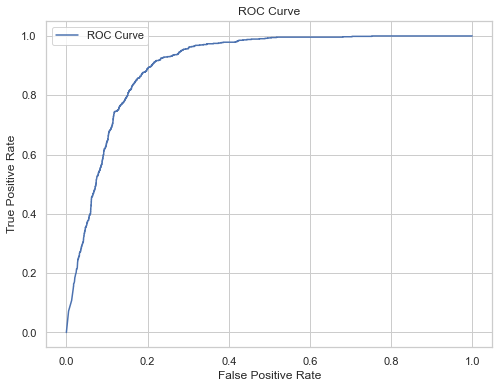

In [66]:
# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 705 and misclassified 55. The ROC curve for this model isnt bad either as it is somewhat close to the upeer left corner. The precision in the model is 0.33, or when it predicts that a consumer is going to open a term deposit, it is correct around 33% of the time. The recall in our model is really good, 93%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening the account.

**Test data set**

Validation Accuracy: 0.793454223794781
Confusion Matrix:
 [[1540  431]
 [  36  254]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      1971
           1       0.37      0.88      0.52       290

    accuracy                           0.79      2261
   macro avg       0.67      0.83      0.69      2261
weighted avg       0.90      0.79      0.82      2261

ROC AUC Score: 0.8856260606378699


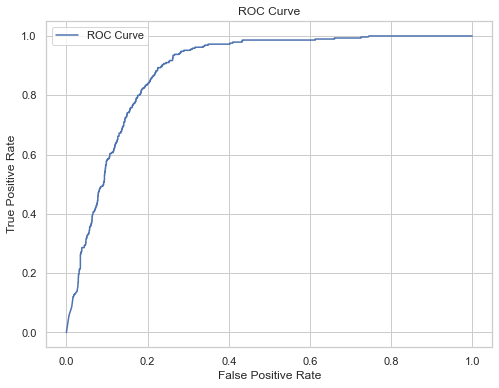

In [67]:
#predicting values
y_test_pred = boost_random.predict(X_test_trans)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 254 and misclassified 36. The ROC curve for this model isnt bad either as it is somewhat close to the upeer left corner. The precision in the model is 0.37 - higher than the validation data set. This means when it predicts that a consumer is going to open a term deposit, it is correct around 37% of the time. The recall for the test data is 88%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.

### AdaBoost Model with original data set - unbalanced

We were curious to see how the model will perform with unbalanced data.

Fitting 5 folds for each of 15 candidates, totalling 75 fits
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=120,
                                                         min_samples_leaf=4,
                                                         min_samples_split=10),
                   learning_rate=0.01, n_estimators=17)
Validation Accuracy: 0.8820406959598939
Confusion Matrix:
 [[5559  463]
 [ 337  423]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6022
           1       0.48      0.56      0.51       760

    accuracy                           0.88      6782
   macro avg       0.71      0.74      0.72      6782
weighted avg       0.89      0.88      0.89      6782

ROC AUC Score: 0.8966279344159136


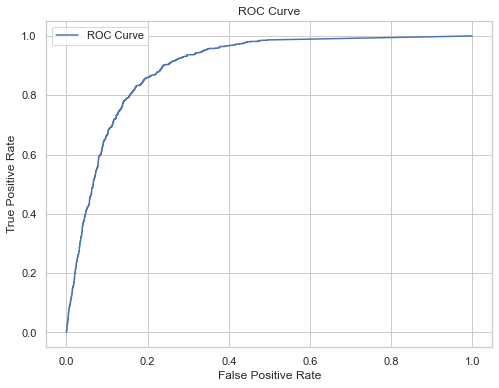

In [68]:
# fitting the model
boost_random.fit(X_train_trans,y_train)

#getting the best hyper parameters
print(boost_random.best_estimator_)

#predicting values
y_val_pred = boost_random.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 423 and misclassified 337. The ROC curve for this model is worse than the balanced data set. You can see it is further from the upper left corner and is a bit unstable. The precision in the model is 0.48, or when it predicts that a consumer is going to open a term deposit, it is correct around 48% of the time. The recall in our model is  56%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  


**Test Data**

Validation Accuracy: 0.874391862007961
Confusion Matrix:
 [[1844  127]
 [ 157  133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1971
           1       0.51      0.46      0.48       290

    accuracy                           0.87      2261
   macro avg       0.72      0.70      0.71      2261
weighted avg       0.87      0.87      0.87      2261

ROC AUC Score: 0.8785685543833867


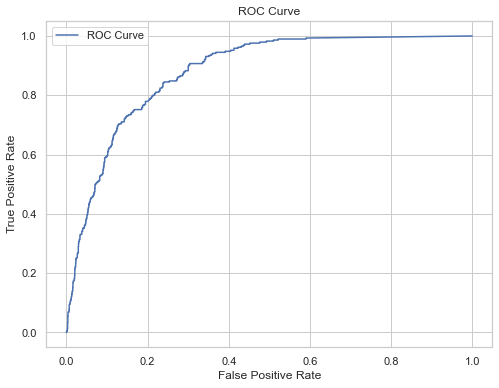

In [69]:
#predicting values
y_test_pred = boost_random.predict(X_test_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = boost_random.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 133 and misclassified 157. The ROC curve for this model is worse than the balanced data set. You can see it is further from the upper left corner and is a bit unstable. The precision in the model is 0.51 - higher than the validation data set. This means when it predicts that a consumer is going to open a term deposit, it is correct around 51% of the time. The recall for the test data is 46%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.

### K Nearest Neighbors with undersampled Dataset

KNN uses a predetermined number of neighbors to classify a new data point - essentially voting. It's easy to implement, easily adapts, and only has one hyper parameter (number of neighbors). Too many neighbors leads to underfitting and too little leads to overfitting. This is why before we implement this method, we need to determine how many neighbors to use.

1 : 105359.56079603038
2 : 81170.51134729967
3 : 75295.72869040346
4 : 71359.99445572162
5 : 68532.56163673602
6 : 65765.3188335528
7 : 63496.56117594133
8 : 61601.56461949223
9 : 60275.74103417696


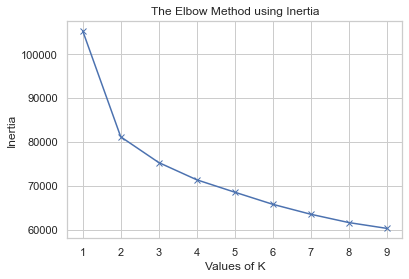

In [76]:
# using grid search to find the best k
inertia = [] # getting the inertia values
mapping = {} # getting the data from the for loop
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train_under,y_train_under)
    inertia.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_
    
    
# plotting the elbow curve
for key, val in mapping.items():
    print(f'{key} : {val}')
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

From the graph above, the "elbow" happens at K=2, so we'll use that value to build the knn model.

In [77]:
# knn model
knn_over = KNeighborsClassifier(n_neighbors = 2).fit(X_train_under,y_train_under)

**Validation Data**

Validation Accuracy: 0.8375110586847537
Confusion Matrix:
 [[5188  834]
 [ 268  492]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      6022
           1       0.37      0.65      0.47       760

    accuracy                           0.84      6782
   macro avg       0.66      0.75      0.69      6782
weighted avg       0.89      0.84      0.86      6782

ROC AUC Score: 0.8287555279763673


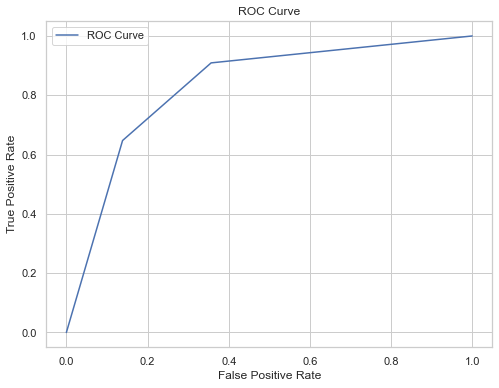

In [78]:
#knn prediction
y_val_pred = knn_over.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = knn_over.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 492 and misclassified 268. The ROC curve for this model is not doing too well. The precision in the model is 0.37, or when it predicts that a consumer is going to open a term deposit, it is correct around 37% of the time. The recall in our model is  65%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  


**Test Data**

Validation Accuracy: 0.8306059265811587
Confusion Matrix:
 [[1708  263]
 [ 120  170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1971
           1       0.39      0.59      0.47       290

    accuracy                           0.83      2261
   macro avg       0.66      0.73      0.68      2261
weighted avg       0.86      0.83      0.84      2261

ROC AUC Score: 0.8155793488339546


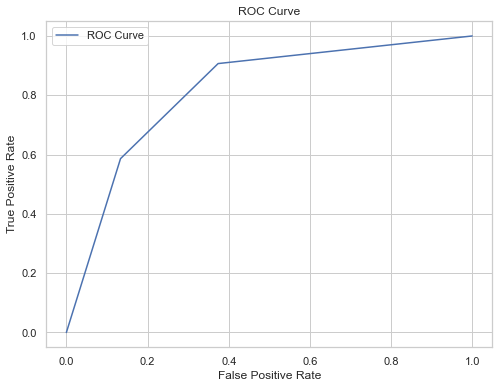

In [79]:
#log reg prediction for test data
y_test_pred = knn_over.predict(X_test_trans)

# Calculate accuracy on the testing set
accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = knn_over.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 170 and misclassified 120. The ROC curve for this model is similar to the validation's curve. The precision in the model is 0.39, or when it predicts that a consumer is going to open a term deposit, it is correct around 39% of the time. The recall in our model is 59%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  

### KNN with originial training data set

1 : 414625.6211568236
2 : 332175.9993844029
3 : 306477.9968675277
4 : 289958.597508619
5 : 278764.5026473816
6 : 268862.07282210607
7 : 261181.16326281006
8 : 255738.49162231904
9 : 250260.55396425328


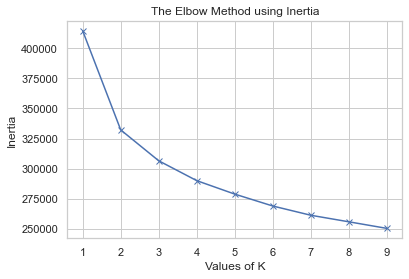

In [80]:
# using grid search to find the best k
inertia = []
mapping = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train_trans, y_train)
    inertia.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_
    
# plotting the elbow curve
for key, val in mapping.items():
    print(f'{key} : {val}')
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

For the original data set, the optimal number of neighbors is also 2 based on the graph above.

In [81]:
# knn model
knn_orig = KNeighborsClassifier(n_neighbors = 2).fit(X_train_trans,y_train)

**Validation Data**

Validation Accuracy: 0.8935417281038042
Confusion Matrix:
 [[5895  127]
 [ 595  165]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      6022
           1       0.57      0.22      0.31       760

    accuracy                           0.89      6782
   macro avg       0.74      0.60      0.63      6782
weighted avg       0.87      0.89      0.87      6782

ROC AUC Score: 0.7462981130591341


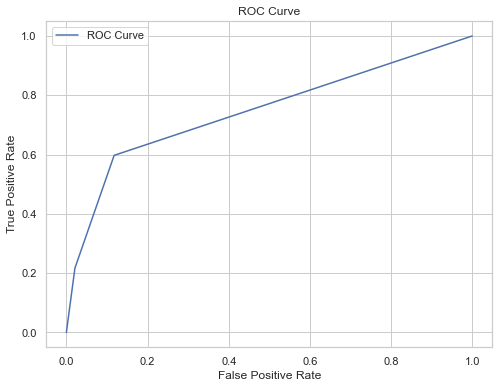

In [82]:
#knn prediction
y_val_pred = knn_orig.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = knn_orig.predict_proba(X_val_trans)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 165 and misclassified 595. The ROC curve for this model is bad. The precision in the model is 0.57, or when it predicts that a consumer is going to open a term deposit, it is correct around 57% of the time. The recall in our model is  22%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  


**Test Data**

Validation Accuracy: 0.8792569659442725
Confusion Matrix:
 [[1938   33]
 [ 240   50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      1971
           1       0.60      0.17      0.27       290

    accuracy                           0.88      2261
   macro avg       0.75      0.58      0.60      2261
weighted avg       0.85      0.88      0.85      2261

ROC AUC Score: 0.726798929302472


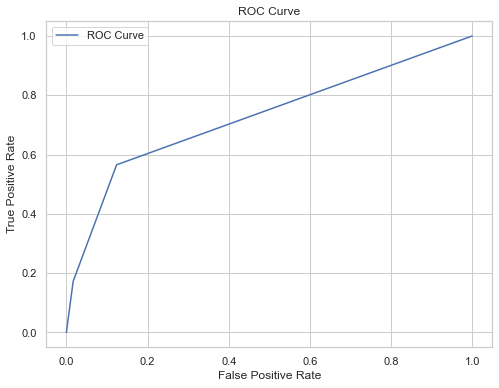

In [83]:
#log reg prediction for test data
y_test_pred = knn_orig.predict(X_test_trans)

# Calculate accuracy on the testing set
accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = knn_orig.predict_proba(X_test_trans)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 170 and misclassified 120. The ROC curve for this model is similar to the validation's curve - still bad. The precision in the model is 0.60, or when it predicts that a consumer is going to open a term deposit, it is correct around 60% of the time. The recall in our model is 17%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  

## Neural Network

### Validation Dataset

Validation Accuracy (Neural Network): 0.875552934237688
Confusion Matrix (Neural Network):
 [[5522  500]
 [ 344  416]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6022
           1       0.45      0.55      0.50       760

    accuracy                           0.88      6782
   macro avg       0.70      0.73      0.71      6782
weighted avg       0.89      0.88      0.88      6782

ROC AUC Score (Neural Network): 0.8807475659424217


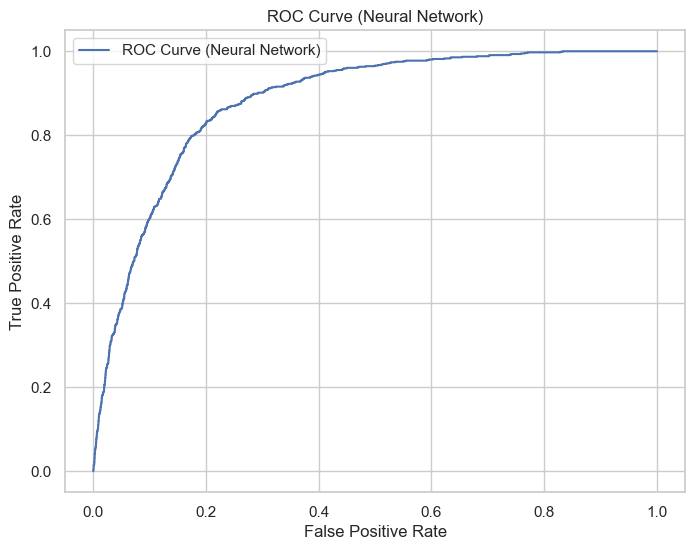

In [117]:
# Create and train a Neural Network model
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
neural_network.fit(X_train_trans, y_train)

# Predict values on the validation set
y_val_pred_nn = neural_network.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_nn = accuracy_score(y_val, y_val_pred_nn)
print("Validation Accuracy (Neural Network):", accuracy_nn)

# Display confusion matrix
confusion_nn = confusion_matrix(y_val, y_val_pred_nn)
print("Confusion Matrix (Neural Network):\n", confusion_nn)

# Conduct classification report
report_nn = classification_report(y_val, y_val_pred_nn)
print("Classification Report (Neural Network):\n", report_nn)

# Calculate ROC AUC
y_prob_nn = neural_network.predict_proba(X_val_trans)[:, 1]
roc_auc_nn = roc_auc_score(y_val, y_prob_nn)
print("ROC AUC Score (Neural Network):", roc_auc_nn)

# Generate ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_val, y_prob_nn)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label="ROC Curve (Neural Network)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Neural Network)")
plt.legend()
plt.show()

### Testing Dataset

Test Accuracy (Neural Network): 0.8637770897832817
Confusion Matrix (Neural Network):
 [[1826  145]
 [ 163  127]]
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1971
           1       0.47      0.44      0.45       290

    accuracy                           0.86      2261
   macro avg       0.69      0.68      0.69      2261
weighted avg       0.86      0.86      0.86      2261

ROC AUC Score (Neural Network): 0.8584754806767089


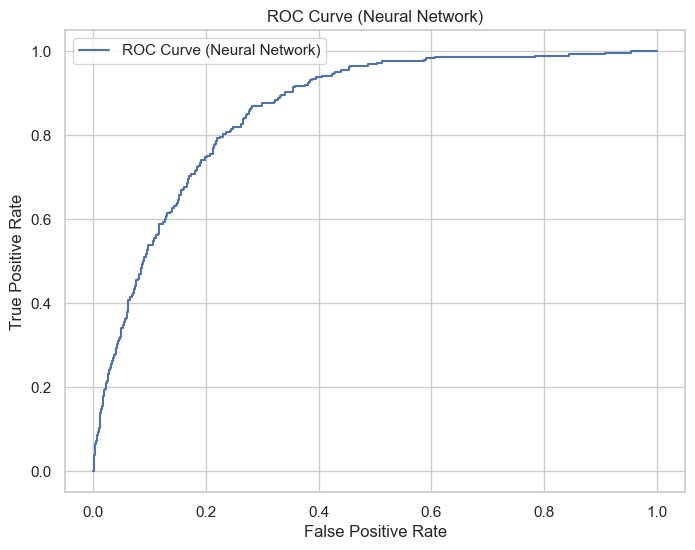

In [118]:
# Create and train a Neural Network model
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=35)
neural_network.fit(X_train_trans, y_train)

# Predict values on the test set
y_test_pred_nn = neural_network.predict(X_test_trans)

# Calculate accuracy on the test set
accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
print("Test Accuracy (Neural Network):", accuracy_nn)

# Display confusion matrix
confusion_nn = confusion_matrix(y_test, y_test_pred_nn)
print("Confusion Matrix (Neural Network):\n", confusion_nn)

# Conduct classification report
report_nn = classification_report(y_test, y_test_pred_nn)
print("Classification Report (Neural Network):\n", report_nn)

# Calculate ROC AUC
y_prob_nn = neural_network.predict_proba(X_test_trans)[:, 1]
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)
print("ROC AUC Score (Neural Network):", roc_auc_nn)

# Generate ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label="ROC Curve (Neural Network)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Neural Network)")
plt.legend()
plt.show()

## Random Forest

### Validation Dataset

Validation Accuracy (Random Forest): 0.8961958124447066
Confusion Matrix (Random Forest):
 [[5706  316]
 [ 388  372]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      6022
           1       0.54      0.49      0.51       760

    accuracy                           0.90      6782
   macro avg       0.74      0.72      0.73      6782
weighted avg       0.89      0.90      0.89      6782

ROC AUC Score (Random Forest): 0.9091128581167299


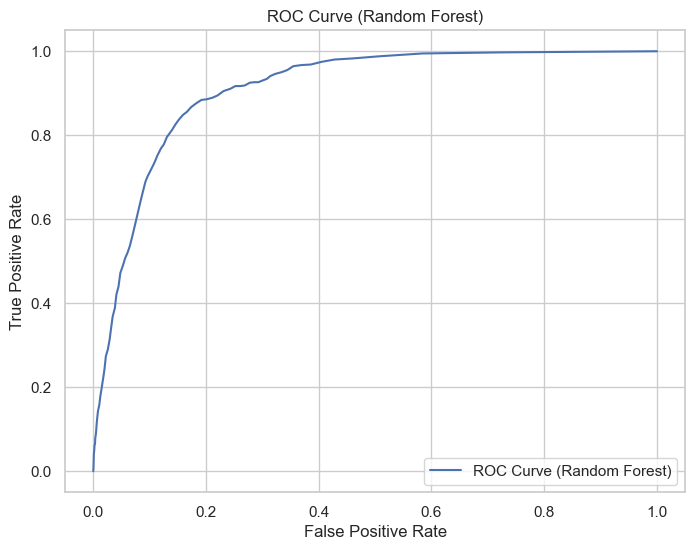

In [119]:
# Create and train a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=35)
random_forest.fit(X_train_trans, y_train)

# Predict values on the validation set
y_val_pred_rf = random_forest.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Validation Accuracy (Random Forest):", accuracy_rf)

# Display confusion matrix
confusion_rf = confusion_matrix(y_val, y_val_pred_rf)
print("Confusion Matrix (Random Forest):\n", confusion_rf)

# Conduct classification report
report_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report (Random Forest):\n", report_rf)

# Calculate ROC AUC
y_prob_rf = random_forest.predict_proba(X_val_trans)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_prob_rf)
print("ROC AUC Score (Random Forest):", roc_auc_rf)

# Generate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

### Testing Dataset

Testing Accuracy (Random Forest): 0.8934099955771783
Confusion Matrix (Random Forest):
 [[1909   62]
 [ 179  111]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1971
           1       0.64      0.38      0.48       290

    accuracy                           0.89      2261
   macro avg       0.78      0.68      0.71      2261
weighted avg       0.88      0.89      0.88      2261

ROC AUC Score (Random Forest): 0.8865620462219423


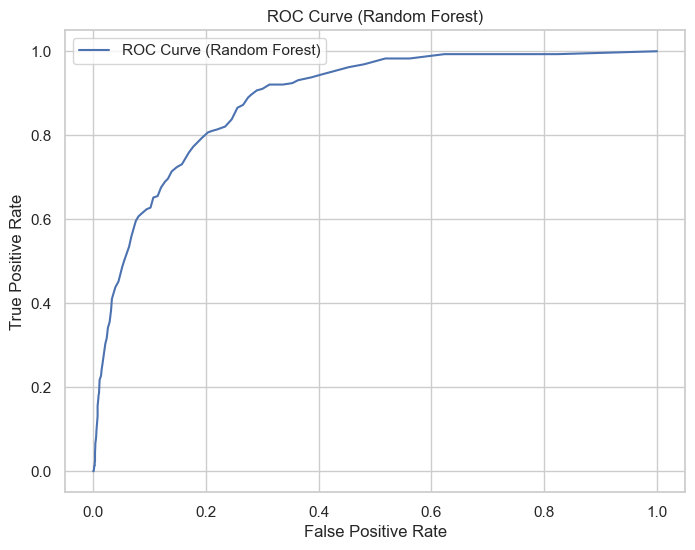

In [121]:
# Predict values on the test set
y_test_pred_rf = random_forest.predict(X_test_trans)

# Calculate accuracy on the test set
accuracy_rf_test = accuracy_score(y_test, y_test_pred_rf)
print("Testing Accuracy (Random Forest):", accuracy_rf_test)

# Display confusion matrix
confusion_rf_test = confusion_matrix(y_test, y_test_pred_rf)
print("Confusion Matrix (Random Forest):\n", confusion_rf_test)

# Conduct classification report
report_rf_test = classification_report(y_test, y_test_pred_rf)
print("Classification Report (Random Forest):\n", report_rf_test)

# Calculate ROC AUC
y_prob_rf_test = random_forest.predict_proba(X_test_trans)[:, 1]
roc_auc_rf_test = roc_auc_score(y_test, y_prob_rf_test)
print("ROC AUC Score (Random Forest):", roc_auc_rf_test)

# Generate ROC curve
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_prob_rf_test)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_test, tpr_rf_test, label="ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

## Support Vector Machine

In [123]:
# Create and train a Support Vector Machine (SVM) model
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_trans, y_train)

SVC(probability=True, random_state=42)

### Validation Dataset

Validation Accuracy (SVM): 0.9076968445886169
Confusion Matrix (SVM):
 [[5873  149]
 [ 477  283]]
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      6022
           1       0.66      0.37      0.47       760

    accuracy                           0.91      6782
   macro avg       0.79      0.67      0.71      6782
weighted avg       0.89      0.91      0.90      6782

ROC AUC Score (SVM): 0.9220671135660474


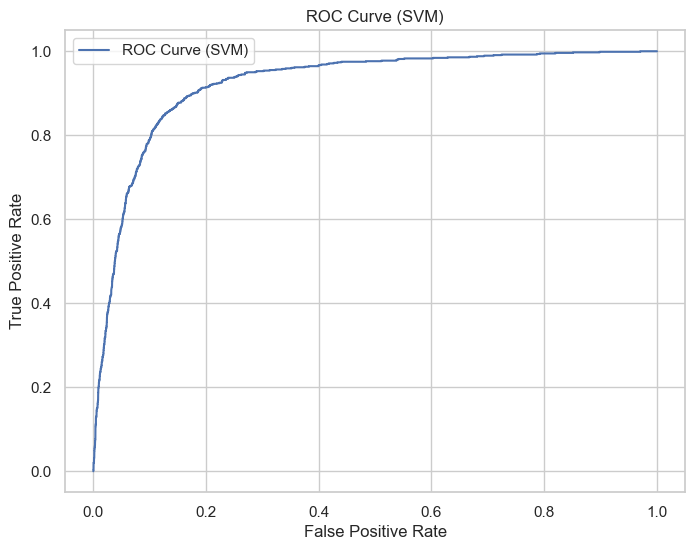

In [124]:
# Predict values on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_trans)

# Calculate accuracy on the validation set
accuracy_v_svm = accuracy_score(y_val, y_val_pred_svm)
print("Validation Accuracy (SVM):", accuracy_v_svm)

# Display confusion matrix
confusion_v_svm = confusion_matrix(y_val, y_val_pred_svm)
print("Confusion Matrix (SVM):\n", confusion_v_svm)

# Conduct classification report
report_v_svm = classification_report(y_val, y_val_pred_svm)
print("Classification Report (SVM):\n", report_v_svm)

# Calculate ROC AUC
y_prob_v_svm = svm_classifier.predict_proba(X_val_trans)[:, 1]
roc_auc_v_svm = roc_auc_score(y_val, y_prob_v_svm)
print("ROC AUC Score (SVM):", roc_auc_v_svm)

# Generate ROC curve
fpr_v_svm, tpr_v_svm, _ = roc_curve(y_val, y_prob_v_svm)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_v_svm, tpr_v_svm, label="ROC Curve (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.show()

### Testing Dataset

Test Accuracy (SVM): 0.8929677134011499
Confusion Matrix (SVM):
 [[1933   38]
 [ 204   86]]
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1971
           1       0.69      0.30      0.42       290

    accuracy                           0.89      2261
   macro avg       0.80      0.64      0.68      2261
weighted avg       0.88      0.89      0.87      2261

ROC AUC Score (SVM): 0.8989065588971116


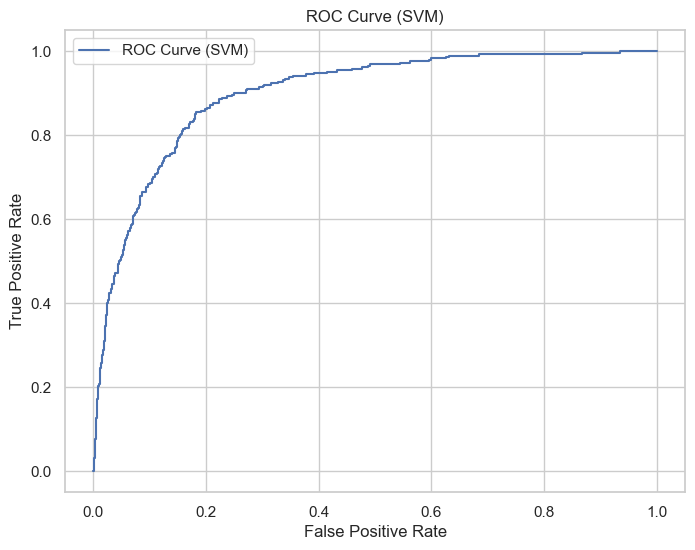

In [125]:
# Predict values on the test set
y_test_pred_svm = svm_classifier.predict(X_test_trans)

# Calculate accuracy on the test set
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print("Test Accuracy (SVM):", accuracy_svm)

# Display confusion matrix
confusion_svm = confusion_matrix(y_test, y_test_pred_svm)
print("Confusion Matrix (SVM):\n", confusion_svm)

# Conduct classification report
report_svm = classification_report(y_test, y_test_pred_svm)
print("Classification Report (SVM):\n", report_svm)

# Calculate ROC AUC
y_prob_svm = svm_classifier.predict_proba(X_test_trans)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print("ROC AUC Score (SVM):", roc_auc_svm)

# Generate ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label="ROC Curve (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.show()

### Classification Tree Fitting with Balanced Dataset

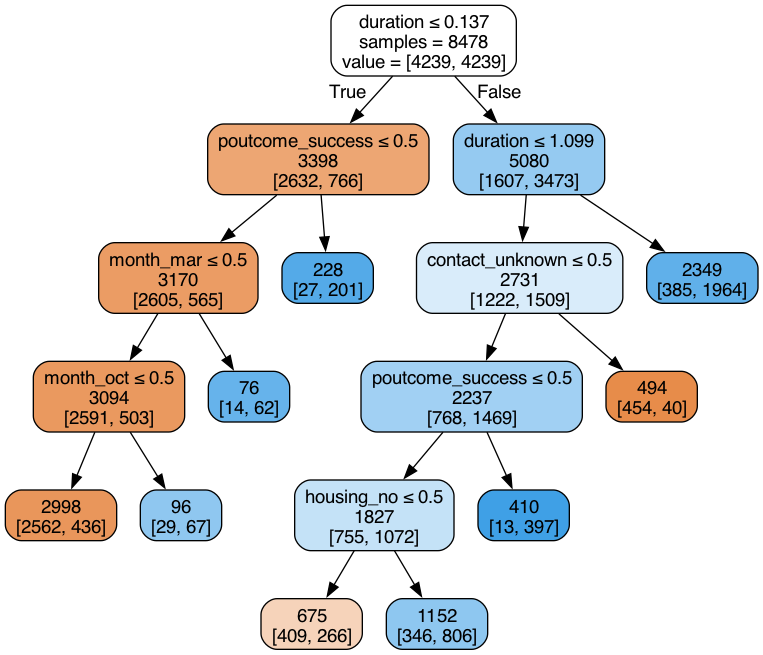

In [82]:
# fit the classification tree - balanced
classTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.005)
classTree.fit(X_train_under, y_train_under)

plotDecisionTree(classTree, feature_names=X_train_under.columns)

#### Model Predictions for balanced dataset (validation)

In [93]:
# predicted classes - balanced
pred_t_class = classTree.predict(X_train_under)
pred_v_class = classTree.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_ct = (classTree.predict_proba(X_val_trans))
class_tree_result = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_ct],
                                  'p(1)': [p[1] for p in pred_prob_v_ct],
                                  'predicted': pred_v_class})
class_tree_result = class_tree_result.sort_values(by=['p(1)'], ascending=False)
class_tree_result.head()

,actual,p(0),p(1),predicted
409,1,0.031707,0.968293,1
4207,0,0.031707,0.968293,1
1696,1,0.031707,0.968293,1
2630,1,0.031707,0.968293,1
6362,1,0.031707,0.968293,1


#### Feature Importance 

In [94]:
# Get feature importances from the Classification Tree - balanced
feature_importances_class = classTree.feature_importances_
class_features_df = pd.DataFrame({'Feature': X_train_under.columns, 'Importance': feature_importances_class})
class_features_df = class_features_df.sort_values(by=['Importance'], ascending=False)
class_features_df.head()

,Feature,Importance
47,duration,0.576993
42,poutcome_success,0.167915
27,contact_unknown,0.146265
21,housing_no,0.043343
35,month_mar,0.034518


#### Confusion Matrix and ROC Curve

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.8165)

       Prediction
Actual    0    1
     0 3425  814
     1  742 3497

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.7778)

       Prediction
Actual    0    1
     0 4624 1398
     1  109  651
True Negatives (TN): 4624
False Positives (FP): 1398
False Negatives (FN): 109
True Positives (TP): 651
Sensitivity (True Positive Rate): 0.86
Specificity (True Negative Rate): 0.77
Type I Error (False Positive Rate): 0.23
Type II Error (False Negative Rate): 0.14
Term subscription rate when predicted not to: 0.023

ROC AUC Score: 0.8537548724850985


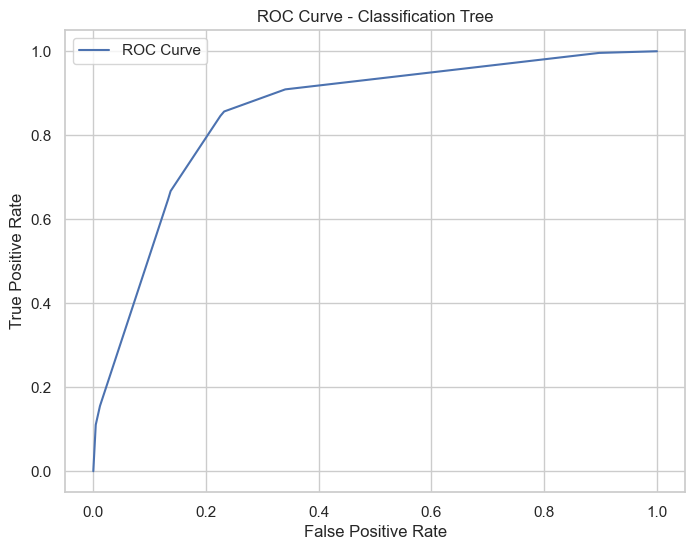

In [106]:
# confusion matrices for classification tree - balanced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train_under, pred_t_class)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_class)

cm_v_class = confusion_matrix(y_val, pred_v_class)

# Assign values to TN, TP, FN, and FP
TN = cm_v_class[0][0]
FP = cm_v_class[0][1]
FN = cm_v_class[1][0]
TP = cm_v_class[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Sensitivity (True Positive Rate): {sensitivity:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - classification tree balanced
y_prob_v_ct = pred_prob_v_ct[:, 1]
roc_auc_v_ct = roc_auc_score(y_val, y_prob_v_ct)
print("\nROC AUC Score:", roc_auc_v_ct)

# Generate ROC curve
fpr_v_ct, tpr_v_ct, _ = roc_curve(y_val, y_prob_v_ct)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_v_ct, tpr_v_ct, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Tree")
plt.legend()
plt.show()

The precision for the testing data is 651/(651+1398) = 32% and the recall is 651/(651+109) = 86% which means that we were able to correctly identify the true positive cases over five sixths of the time while having a positive predicitve rate that is just under one third of our total positive predictions. The ROC curve is not as great as some of the other models.

#### Test Data

In [116]:
# predicted classes - balanced
pred_test_class = classTree.predict(X_test_trans)

# predicted probabilities for testing set
pred_prob_test_ct = (classTree.predict_proba(X_test_trans))
class_tree_results = pd.DataFrame({'actual': y_test.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_test_ct],
                                  'p(1)': [p[1] for p in pred_prob_test_ct],
                                  'predicted': pred_test_class})
class_tree_results = class_tree_results.sort_values(by=['p(1)'], ascending=False)
class_tree_results.head()

,actual,p(0),p(1),predicted
1469,1,0.031707,0.968293,1
2227,1,0.031707,0.968293,1
1204,1,0.031707,0.968293,1
1671,1,0.031707,0.968293,1
286,1,0.031707,0.968293,1



Testing Set: Confusion matrix

Confusion Matrix (Accuracy 0.8085)

       Prediction
Actual    0    1
     0 1607  364
     1   69  221
True Negatives (TN): 1607
False Positives (FP): 364
False Negatives (FN): 69
True Positives (TP): 221
Recall (True Positive Rate): 0.76
Precision (Positive Predictive Value): 0.38
Specificity (True Negative Rate): 0.82
Type I Error (False Positive Rate): 0.18
Type II Error (False Negative Rate): 0.24
Term subscription rate when predicted not to: 0.041

ROC AUC Score: 0.8345641106387445


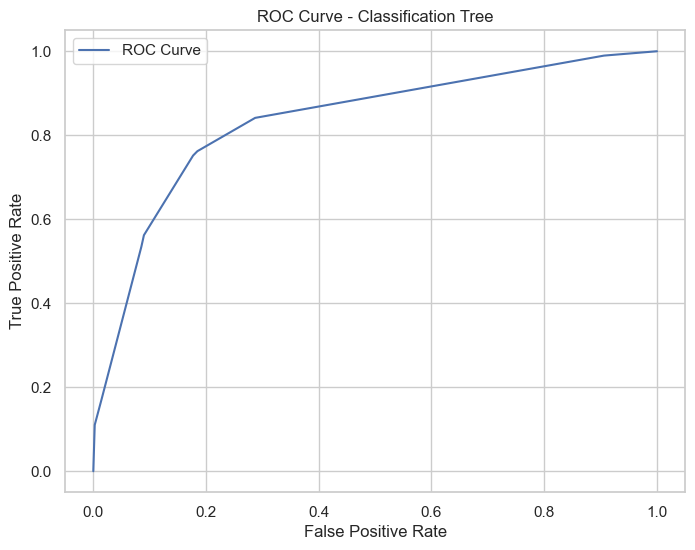

In [107]:
# confusion matrix for balanced classification tree - testing
print("\nTesting Set: Confusion matrix\n")
classificationSummary(y_test, pred_test_class)

cm_test_class = confusion_matrix(y_test, pred_test_class)

# Assign values to TN, TP, FN, and FP
TN = cm_test_class[0][0]
FP = cm_test_class[0][1]
FN = cm_test_class[1][0]
TP = cm_test_class[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Recall (True Positive Rate): {sensitivity:.2f}')
print(f'Precision (Positive Predictive Value): {precision:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - classification tree balanced
y_prob_ct = pred_prob_test_ct[:, 1]
roc_auc_ct = roc_auc_score(y_test, y_prob_ct)
print("\nROC AUC Score:", roc_auc_ct)

# Generate ROC curve
fpr_ct, tpr_ct, _ = roc_curve(y_test, y_prob_ct)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Tree")
plt.legend()
plt.show()

The precision for the testing data is 221/(221+364) = 38% and the recall is 221/(221+69) = 76% which means that we were able to correctly identify the true positive cases over three fourths of the time while having a positive predicitve rate that is over one third of our total positive predictions. The ROC curve is not as great as some of the other models.

### Classification Tree Fitting with Imbalanced Dataset

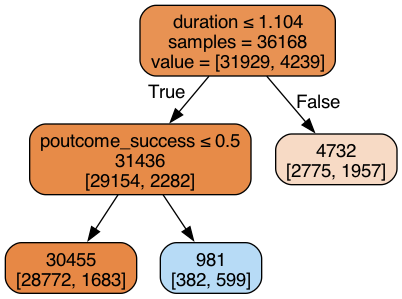

In [83]:
# fit the classification tree - imbalanced
classTree2 = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.005)
classTree2.fit(X_train_trans, y_train)

plotDecisionTree(classTree2, feature_names=X_train_trans.columns)

#### Model Predictions for imbalanced dataset (validation)

In [85]:
# predicted classes - imbalanced
pred_t_class2 = classTree2.predict(X_train_trans)
pred_v_class2 = classTree2.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_ct2 = (classTree2.predict_proba(X_val_trans))
class_tree_result2 = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_ct2],
                                  'p(1)': [p[1] for p in pred_prob_v_ct2],
                                  'predicted': pred_v_class2})
class_tree_result2 = class_tree_result2.sort_values(by=['p(1)'], ascending=False)
class_tree_result2.head()

,actual,p(0),p(1),predicted
280,1,0.389399,0.610601,1
1175,1,0.389399,0.610601,1
6479,1,0.389399,0.610601,1
2464,0,0.389399,0.610601,1
2630,1,0.389399,0.610601,1


#### Feature Importance

In [87]:
# Get feature importances from the Classification Tree - imbalanced
feature_importances_class2 = classTree2.feature_importances_
class_features_df2 = pd.DataFrame({'Feature': X_train_trans.columns, 'Importance': feature_importances_class2})
class_features_df2 = class_features_df2.sort_values(by=['Importance'], ascending=False)
class_features_df2.head()

,Feature,Importance
47,duration,0.619982
42,poutcome_success,0.380018
0,job_admin.,0.000000
37,month_nov,0.000000
28,month_apr,0.000000


#### Confusion Matrix and ROC Curve

Training Set: Confusion matrix

Confusion Matrix (Accuracy 0.8888)

       Prediction
Actual     0     1
     0 31547   382
     1  3640   599

Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.8949)

       Prediction
Actual    0    1
     0 5951   71
     1  642  118
True Negatives (TN): 5951
False Positives (FP): 71
False Negatives (FN): 642
True Positives (TP): 118
Sensitivity (True Positive Rate): 0.16
Specificity (True Negative Rate): 0.99
Type I Error (False Positive Rate): 0.01
Type II Error (False Negative Rate): 0.84
Term subscription rate when predicted not to: 0.097

ROC AUC Score: 0.7638091253124508


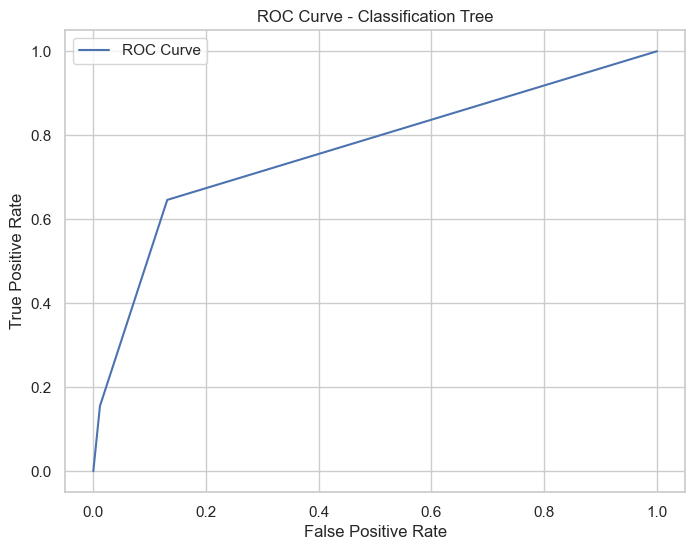

In [115]:
# confusion matrices for classification tree - imbalaced
print('Training Set: Confusion matrix\n')
classificationSummary(y_train, pred_t_class2)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_class2)

cm_v_class2 = confusion_matrix(y_val, pred_v_class2)

# Assign values to TN, TP, FN, and FP
TN2 = cm_v_class2[0][0]
FP2 = cm_v_class2[0][1]
FN2 = cm_v_class2[1][0]
TP2 = cm_v_class2[1][1]

# Calculate sensitivity and specificity
sensitivity2 = TP2 / (TP2 + FN2)
specificity2 = TN2 / (TN2 + FP2)

# Calculate Type I and Type II errors
type_I_error2 = FP2 / (FP2 + TN2)
type_II_error2 = FN2 / (FN2 + TP2)

inaccuracy_of_0_pred2 = FN2 / (TN2 + FN2)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN2}')
print(f'False Positives (FP): {FP2}')
print(f'False Negatives (FN): {FN2}')
print(f'True Positives (TP): {TP2}')
print(f'Sensitivity (True Positive Rate): {sensitivity2:.2f}')
print(f'Specificity (True Negative Rate): {specificity2:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error2:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error2:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred2:.3f}')

# Calculate ROC AUC - classification tree imbalanced
y_prob_v_ct2 = pred_prob_v_ct2[:, 1]
roc_auc_v_ct2 = roc_auc_score(y_val, y_prob_v_ct2)
print("\nROC AUC Score:", roc_auc_v_ct2)

# Generate ROC curve
fpr_v_ct2, tpr_v_ct2, _ = roc_curve(y_val, y_prob_v_ct2)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_v_ct2, tpr_v_ct2, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Tree")
plt.legend()
plt.show()

The precision for the testing data is 118/(118+71) = 62% and the recall is 118/(118+642) = 16% which means that we were able to correctly identify the true positive cases only about one sixth of the time while having a positive predicitve rate that is over three fifths of our total positive predictions. The ROC curve is not good for the imbalanced validation set.

#### Test Data

In [113]:
# predicted classes - imbalanced
pred_test_class2 = classTree2.predict(X_test_trans)

# predicted probabilities for testing set
pred_prob_test_ct2 = (classTree2.predict_proba(X_test_trans))
class_tree_results2 = pd.DataFrame({'actual': y_test.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_test_ct2],
                                  'p(1)': [p[1] for p in pred_prob_test_ct2],
                                  'predicted': pred_test_class2})
class_tree_results2 = class_tree_results2.sort_values(by=['p(1)'], ascending=False)
class_tree_results2.head()

,actual,p(0),p(1),predicted
1910,1,0.389399,0.610601,1
1036,0,0.389399,0.610601,1
113,1,0.389399,0.610601,1
1631,1,0.389399,0.610601,1
1383,1,0.389399,0.610601,1



Testing Set: Confusion matrix

Confusion Matrix (Accuracy 0.8810)

       Prediction
Actual    0    1
     0 1943   28
     1  241   49
True Negatives (TN): 1943
False Positives (FP): 28
False Negatives (FN): 241
True Positives (TP): 49
Recall (True Positive Rate): 0.17
Precision (Positive Predictive Value): 0.64
Specificity (True Negative Rate): 0.99
Type I Error (False Positive Rate): 0.01
Type II Error (False Negative Rate): 0.83
Term subscription rate when predicted not to: 0.110

ROC AUC Score: 0.7286604034360292


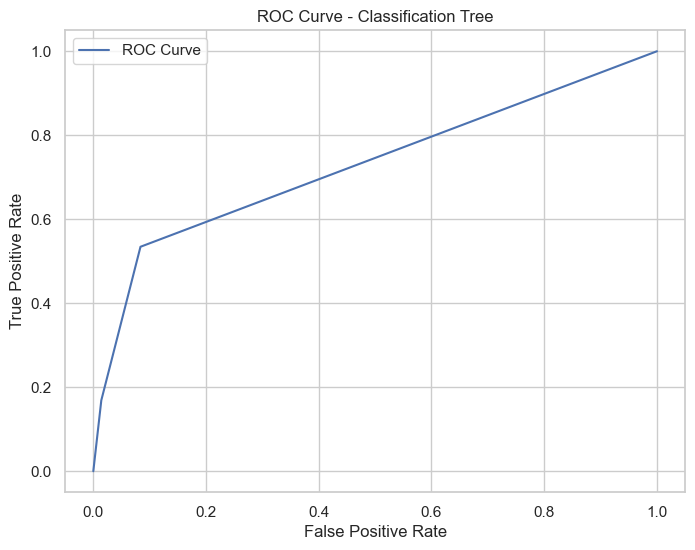

In [114]:
# confusion matrix for imbalanced classification tree - testing
print("\nTesting Set: Confusion matrix\n")
classificationSummary(y_test, pred_test_class2)

cm_test_class2 = confusion_matrix(y_test, pred_test_class2)

# Assign values to TN, TP, FN, and FP
TN = cm_test_class2[0][0]
FP = cm_test_class2[0][1]
FN = cm_test_class2[1][0]
TP = cm_test_class2[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Recall (True Positive Rate): {sensitivity:.2f}')
print(f'Precision (Positive Predictive Value): {precision:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - classification tree imbalanced
y_prob_ct2 = pred_prob_test_ct2[:, 1]
roc_auc_ct2 = roc_auc_score(y_test, y_prob_ct2)
print("\nROC AUC Score:", roc_auc_ct2)

# Generate ROC curve
fpr_ct2, tpr_ct2, _ = roc_curve(y_test, y_prob_ct2)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct2, tpr_ct2, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Classification Tree")
plt.legend()
plt.show()

The precision for the testing data is 49/(49+28) = 64% and the recall is 49/(49+241) = 17% which means that we were able to correctly identify the true positive cases less than one fifth of the time while having a positive predictive rate that is greater than three fifths of our total positive predictions. The ROC curve is not good for the imbalanced test set.

### Logistic Regression with undersampled training data  

Another candidate model is Logistic Regression. Logistic regression is nice because it provides probabilities of how likely someone is to open a term deposit. It is also simple to use and implement, along with providing which characteristics are important to the model.

In [64]:
# Create a logistic regression model - balanced
log_reg = LogisticRegression(random_state=1)
log_reg.fit(X_train_under, y_train_under)

LogisticRegression(random_state=1)

**Validation Data**

In [66]:
# predicted classes - balanced
pred_t_lr = log_reg.predict(X_train_under)
pred_v_lr = log_reg.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_lr = (log_reg.predict_proba(X_val_trans))
lr_result = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_lr],
                                  'p(1)': [p[1] for p in pred_prob_v_lr],
                                  'predicted': pred_v_lr})
lr_result = lr_result.sort_values(by=['p(1)'], ascending=False)
lr_result.head()

,actual,p(0),p(1),predicted
364,1,0.000233,0.999767,1
1492,1,0.000242,0.999758,1
6765,1,0.000245,0.999755,1
1402,1,0.000307,0.999693,1
5619,1,0.000346,0.999654,1



Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.8001)

       Prediction
Actual    0    1
     0 4757 1265
     1   91  669
True Negatives (TN): 4757
False Positives (FP): 1265
False Negatives (FN): 91
True Positives (TP): 669
Sensitivity (True Positive Rate): 0.88
Specificity (True Negative Rate): 0.79
Type I Error (False Positive Rate): 0.21
Type II Error (False Negative Rate): 0.12
Term subscription rate when predicted not to: 0.019

ROC AUC Score: 0.9139761663374644


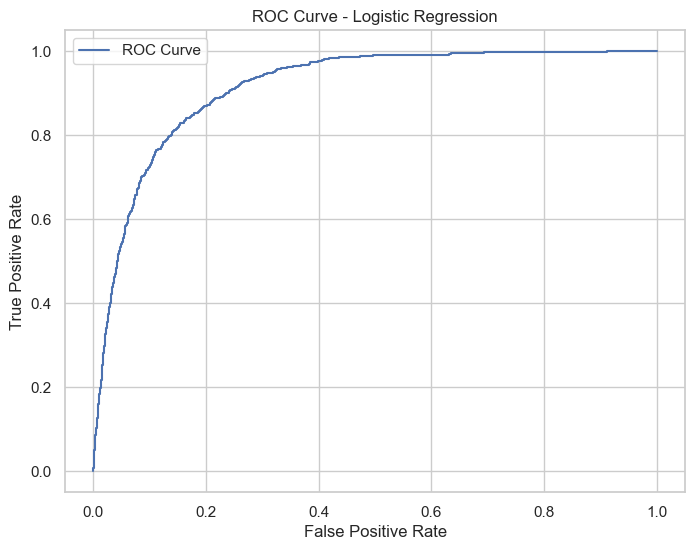

In [78]:
# confusion matrix for logistic regression - balanced
#print('Training Set: Confusion matrix\n')
#classificationSummary(y_train_under, pred_t_lr)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_lr)

cm_v_lr = confusion_matrix(y_val, pred_v_lr)

# Assign values to TN, TP, FN, and FP
TN = cm_v_lr[0][0]
FP = cm_v_lr[0][1]
FN = cm_v_lr[1][0]
TP = cm_v_lr[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Sensitivity (True Positive Rate): {sensitivity:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - logistic regression balanced
y_prob_v_lr = pred_prob_v_lr[:, 1]
roc_auc_v_lr = roc_auc_score(y_val, y_prob_v_lr)
print("\nROC AUC Score:", roc_auc_v_lr)

# Generate ROC curve
fpr_v_lr, tpr_v_lr, _ = roc_curve(y_val, y_prob_v_lr)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr_v_lr, tpr_v_lr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 669 and misclassified 91. The ROC curve for this model is pretty good. The precision in the model is 0.346, or when it predicts that a consumer is going to open a term deposit, it is correct around 34.6% of the time. The recall in our model is 88%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account. 

**Test Data**

In [112]:
# predicted classes - balanced
pred_test_lr = log_reg.predict(X_test_trans)

# predicted probabilities for testing set
pred_prob_test_lr = (log_reg.predict_proba(X_test_trans))
lr_results = pd.DataFrame({'actual': y_test.values.ravel(),
                           'p(0)': [p[0] for p in pred_prob_test_lr],
                           'p(1)': [p[1] for p in pred_prob_test_lr],
                           'predicted': pred_test_lr})
lr_results = lr_results.sort_values(by=['p(1)'], ascending=False)
lr_results.head()

,actual,p(0),p(1),predicted
1009,1,0.000675,0.999325,1
1351,1,0.000924,0.999076,1
2227,1,0.001615,0.998385,1
1224,1,0.001632,0.998368,1
779,1,0.002016,0.997984,1



Testing Set: Confusion matrix

Confusion Matrix (Accuracy 0.8032)

       Prediction
Actual    0    1
     0 1580  391
     1   54  236
True Negatives (TN): 1580
False Positives (FP): 391
False Negatives (FN): 54
True Positives (TP): 236
Recall (True Positive Rate): 0.81
Precision (Positive Predictive Value): 0.38
Specificity (True Negative Rate): 0.80
Type I Error (False Positive Rate): 0.20
Type II Error (False Negative Rate): 0.19
Term subscription rate when predicted not to: 0.033

ROC AUC Score: 0.8894347346874508


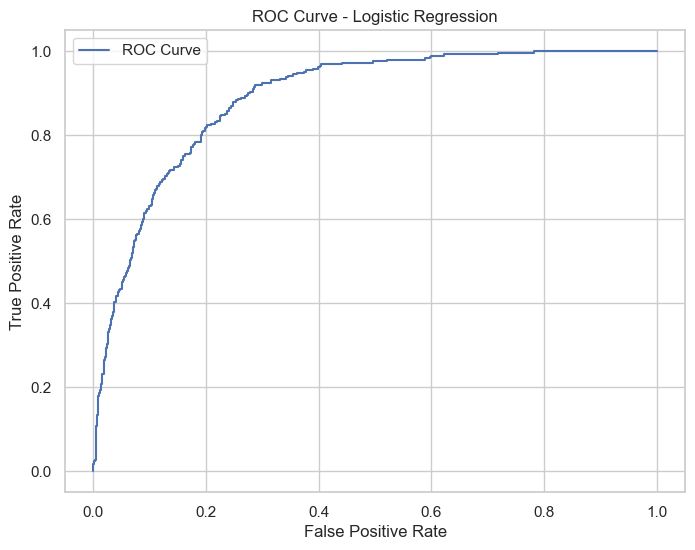

In [77]:
# confusion matrix for balanced logistic regression - testing
print("\nTesting Set: Confusion matrix\n")
classificationSummary(y_test, pred_test_lr)

cm_test_lr = confusion_matrix(y_test, pred_test_lr)

# Assign values to TN, TP, FN, and FP
TN = cm_test_lr[0][0]
FP = cm_test_lr[0][1]
FN = cm_test_lr[1][0]
TP = cm_test_lr[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Recall (True Positive Rate): {sensitivity:.2f}')
print(f'Precision (Positive Predictive Value): {precision:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - logistic regression balanced
y_prob_lr = pred_prob_test_lr[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("\nROC AUC Score:", roc_auc_lr)

# Generate ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 236 and misclassified 54. The ROC curve for this model is pretty good. The precision in the model is 0.376, or when it predicts that a consumer is going to open a term deposit, it is correct around 37.6% of the time. The recall in our model is  81.4%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account. 

### Logistic Regression with original training data - unbalanced

Here, we're building a logistic regression model to the original data set with the imbalanced data set.

In [70]:
# Create a logistic regression model - imbalanced
log_reg2 = LogisticRegression(random_state=2)
log_reg2.fit(X_train_trans, y_train)

LogisticRegression(random_state=2)

**Validation Data**

In [71]:
# predicted classes - imbalanced
pred_t_lr2 = log_reg2.predict(X_train_trans)
pred_v_lr2 = log_reg2.predict(X_val_trans)

# predicted probabilities for validation set
pred_prob_v_lr2 = (log_reg2.predict_proba(X_val_trans))
lr_result2 = pd.DataFrame({'actual': y_val.values.ravel(),
                                  'p(0)': [p[0] for p in pred_prob_v_lr2],
                                  'p(1)': [p[1] for p in pred_prob_v_lr2],
                                  'predicted': pred_v_lr2})
lr_result2 = lr_result2.sort_values(by=['p(1)'], ascending=False)
lr_result2.head()

,actual,p(0),p(1),predicted
1492,1,0.004696,0.995304,1
364,1,0.005153,0.994847,1
1402,1,0.006540,0.993460,1
6765,1,0.008117,0.991883,1
996,0,0.008256,0.991744,1



Validation Set: Confusion matrix

Confusion Matrix (Accuracy 0.9067)

       Prediction
Actual    0    1
     0 5822  200
     1  433  327
True Negatives (TN): 5822
False Positives (FP): 200
False Negatives (FN): 433
True Positives (TP): 327
Sensitivity (True Positive Rate): 0.43
Specificity (True Negative Rate): 0.97
Type I Error (False Positive Rate): 0.03
Type II Error (False Negative Rate): 0.57
Term subscription rate when predicted not to: 0.069

ROC AUC Score: 0.9129693317485011


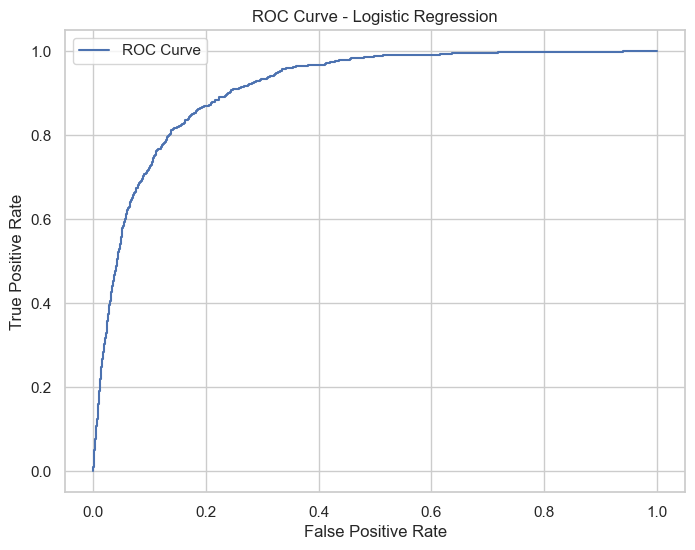

In [79]:
# confusion matrix for logistic regression - imbalanced
#print('Training Set: Confusion matrix\n')
#classificationSummary(y_train_under, pred_t_lr2)
print("\nValidation Set: Confusion matrix\n")
classificationSummary(y_val, pred_v_lr2)

cm_v_lr2 = confusion_matrix(y_val, pred_v_lr2)

# Assign values to TN, TP, FN, and FP
TN = cm_v_lr2[0][0]
FP = cm_v_lr2[0][1]
FN = cm_v_lr2[1][0]
TP = cm_v_lr2[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Sensitivity (True Positive Rate): {sensitivity:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - logistic regression balanced
y_prob_v_lr2 = pred_prob_v_lr2[:, 1]
roc_auc_v_lr2 = roc_auc_score(y_val, y_prob_v_lr2)
print("\nROC AUC Score:", roc_auc_v_lr2)

# Generate ROC curve
fpr_v_lr2, tpr_v_lr2, _ = roc_curve(y_val, y_prob_v_lr2)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr_v_lr2, tpr_v_lr2, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In the validation data set, there are 760 rare events. The model correctly classified 327 and misclassified 433. The ROC curve for this model is similar to the balanced data set. The precision in the model is 0.62, or when it predicts that a consumer is going to open a term deposit, it is correct around 62% of the time. The recall in our model is 43%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  

**Test Data**

In [110]:
# predicted classes - imbalanced
pred_test_lr2 = log_reg2.predict(X_test_trans)

# predicted probabilities for test set
pred_prob_test_lr2 = (log_reg2.predict_proba(X_test_trans))
lr_results2 = pd.DataFrame({'actual': y_test.values.ravel(),
                           'p(0)': [p[0] for p in pred_prob_test_lr2],
                           'p(1)': [p[1] for p in pred_prob_test_lr2],
                           'predicted': pred_test_lr2})
lr_results2 = lr_results2.sort_values(by=['p(1)'], ascending=False)
lr_results2.head()

,actual,p(0),p(1),predicted
1009,1,0.015212,0.984788,1
1351,1,0.019928,0.980072,1
1224,1,0.033884,0.966116,1
278,0,0.043104,0.956896,1
779,1,0.043321,0.956679,1



Testing Set: Confusion matrix

Confusion Matrix (Accuracy 0.8912)

       Prediction
Actual    0    1
     0 1915   56
     1  190  100
True Negatives (TN): 1915
False Positives (FP): 56
False Negatives (FN): 190
True Positives (TP): 100
Recall (True Positive Rate): 0.34
Precision (Positive Predictive Value): 0.64
Specificity (True Negative Rate): 0.97
Type I Error (False Positive Rate): 0.03
Type II Error (False Negative Rate): 0.66
Term subscription rate when predicted not to: 0.090

ROC AUC Score: 0.88985461607096


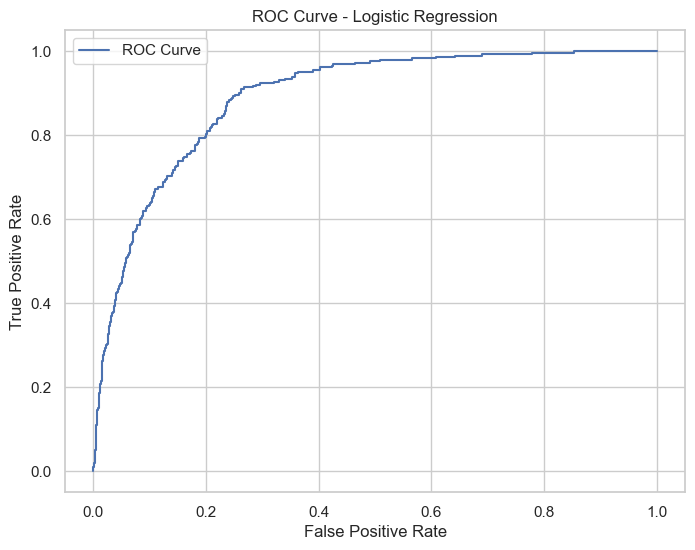

In [111]:
# confusion matrix for imbalanced logistic regression - testing
print("\nTesting Set: Confusion matrix\n")
classificationSummary(y_test, pred_test_lr2)

cm_test_lr2 = confusion_matrix(y_test, pred_test_lr2)

# Assign values to TN, TP, FN, and FP
TN = cm_test_lr2[0][0]
FP = cm_test_lr2[0][1]
FN = cm_test_lr2[1][0]
TP = cm_test_lr2[1][1]

# Calculate sensitivity and specificity
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

# Calculate Type I and Type II errors
type_I_error = FP / (FP + TN)
type_II_error = FN / (FN + TP)

inaccuracy_of_0_pred = FN / (TN + FN)

# Print sensitivity, specificity, and error
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Positives (TP): {TP}')
print(f'Recall (True Positive Rate): {sensitivity:.2f}')
print(f'Precision (Positive Predictive Value): {precision:.2f}')
print(f'Specificity (True Negative Rate): {specificity:.2f}')
print(f'Type I Error (False Positive Rate): {type_I_error:.2f}')
print(f'Type II Error (False Negative Rate): {type_II_error:.2f}')
print(f'Term subscription rate when predicted not to: {inaccuracy_of_0_pred:.3f}')

# Calculate ROC AUC - logistic regression balanced
y_prob_lr2 = pred_prob_test_lr2[:, 1]
roc_auc_lr2 = roc_auc_score(y_test, y_prob_lr2)
print("\nROC AUC Score:", roc_auc_lr2)

# Generate ROC curve
fpr_lr2, tpr_lr2, _ = roc_curve(y_test, y_prob_lr2)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr2, tpr_lr2, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In the test data set, there are 290 rare events. The model correctly classified 100 and misclassified 190. The ROC curve for this model is similar to the validation's curve. The precision in the model is 0.641, or when it predicts that a consumer is going to open a term deposit, it is correct around 64.1% of the time. The recall in our model is 34.5%. Meaning for all the consumers that are going to open a term deposit, recall tells us how many we correctly identified as opening an account.  

### Conclusion/Recommendations

While the imbalanced data often performs better in terms of accuracy for the models, it does not do as well of a job of correctly classifying term deposit subscriptions in the validation dataset. In our business objective, there is much more to be gained from term deposit subscriptions than not which allows for the imperfect predictions of the balanced dataset to outweigh the imbalanced for the models.

### References

Direct-Mail Fundraising. (n.d.). Kaggle.com. Retrieved October 13, 2023, from https://www.kaggle.com/code/sajaabdalaal/direct-mail-fundraising#Model-Training

Shmueli, G., Bruce, P. C., Gedeck, P., & Patel, N. R. (2020). Data mining for business analytics: Concepts, techniques and applications in Python. Wiley.

UCI Machine Learning Repository. (n.d.). Archive.ics.uci.edu. https://archive.ics.uci.edu/dataset/222/bank+marketing

